# Label transfer uncertainty per category, broken down into cell types

Here we plot label transfer uncertainty for several covariates (lung condition, single cell platform, tissue sampling method), broken down by cell type. We moreover take a quick look at detection of the rare immune cell type "migratory DCs" in the datasets mapped to the atlas.

Load modules:

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import copy
import os

for pretty code formatting:

In [2]:
%load_ext lab_black

set figure parameters and initiate empty dictionary in which to store paper figures:

In [3]:
sc.set_figure_params(dpi=140, fontsize=10)

In [4]:
FIGURES = dict()

set paths:

In [5]:
path_adata_ext = (
    "../../data/HLCA_extended/HLCA_extended/extension_data_pooled_raw_2000genes.h5ad"
)
path_ct_df = "../../supporting_files/celltype_structure_and_colors/manual_anns_and_leveled_anns_ordered.csv"
path_label_tr_res = (
    "../../results/HLCA_ext_label_transfer/transfered_labels_query_only.csv"
)
dir_figures = "../../results/figures/"

load files:

In [6]:
ext = sc.read_h5ad(path_adata_ext)

In [7]:
ct_df = pd.read_csv(
    path_ct_df,
    index_col=0,
)

In [8]:
trans = pd.read_csv(path_label_tr_res, index_col=0)

set parameters:

In [9]:
unc_thres = 0.2  # uncertainty threshold above which cells are labeled Unknown

### Migratory DCs detected via label transfer:

In [10]:
trans.columns

Index(['most_confident_level', 'most_confident_uncert', 'most_confident_label',
       'transf_ann_level_5_uncert', 'transf_ann_level_5_label',
       'transf_ann_level_4_uncert', 'transf_ann_level_4_label',
       'transf_ann_level_3_uncert', 'transf_ann_level_3_label',
       'transf_ann_level_2_uncert', 'transf_ann_level_2_label',
       'transf_ann_level_1_uncert', 'transf_ann_level_1_label'],
      dtype='object')

In [11]:
tra_mig_dcs_all = trans.loc[trans.transf_ann_level_4_label == "Migratory DCs", :].copy()
tra_dcs_all = trans.loc[trans.transf_ann_level_3_label == "Dendritic cells", :].copy()

filter based on uncertainty:

In [12]:
tra_mig_dcs = tra_mig_dcs_all.loc[
    tra_mig_dcs_all.transf_ann_level_4_uncert < unc_thres, :
].copy()
tra_dcs = tra_dcs_all.loc[tra_dcs_all.transf_ann_level_4_uncert < unc_thres, :].copy()

check studies matching with these cells:

In [13]:
ext_dcs = ext[tra_dcs.index, :].copy()

Do a simple total counts normalization:

In [14]:
median_counts = np.median(ext_dcs.X.toarray().sum(axis=1))

In [15]:
sc.pp.normalize_per_cell(ext_dcs, counts_per_cell_after=median_counts)

log-transform:

In [16]:
sc.pp.log1p(ext_dcs)

subset to mig dcs for cell counts:

In [17]:
ext_mig_dcs = ext_dcs[tra_mig_dcs.index, :].copy()

Count number of mig dcs and total cells:

In [18]:
mig_dc_counts = ext_mig_dcs.obs.study.value_counts()

In [19]:
cell_counts = pd.DataFrame(ext.obs.study.value_counts())
cell_counts.rename(columns={"study": "total_n_cells"}, inplace=True)
cell_counts["n_mig_dcs"] = 0
cell_counts.loc[mig_dc_counts.index, "n_mig_dcs"] = mig_dc_counts.values

In [20]:
tra_mig_dcs.columns

Index(['most_confident_level', 'most_confident_uncert', 'most_confident_label',
       'transf_ann_level_5_uncert', 'transf_ann_level_5_label',
       'transf_ann_level_4_uncert', 'transf_ann_level_4_label',
       'transf_ann_level_3_uncert', 'transf_ann_level_3_label',
       'transf_ann_level_2_uncert', 'transf_ann_level_2_label',
       'transf_ann_level_1_uncert', 'transf_ann_level_1_label'],
      dtype='object')

In [21]:
print(
    "Number of migratory dcs identified with label transfer",
    tra_mig_dcs.shape[0],
)
print(
    "Number of datasets with migratory DCs:",
    len(ext.obs.loc[tra_mig_dcs.index, "dataset"].unique()),
    "out of",
    len(ext.obs.dataset.unique()),
)
print(
    "Percentage of detected migratory DCs among all extension datasets:",
    round(tra_mig_dcs.shape[0] / ext.shape[0] * 100, 2),
)

Number of migratory dcs identified with label transfer 2048
Number of datasets with migratory DCs: 28 out of 37
Percentage of detected migratory DCs among all extension datasets: 0.11


add information on DCs:

In [22]:
ext_dcs.obs["DC type"] = "Other DCs"
ext_dcs.obs.loc[tra_mig_dcs.index, "DC type"] = "MDCs"

turn cell counts into dictionaries so we can format our x label names for the figure:

In [23]:
study_to_nmigdcs = dict(cell_counts.n_mig_dcs)
study_to_ncells = dict(cell_counts.total_n_cells)
# convert to thousands for readability
for study, n_cells in study_to_ncells.items():
    k_cells = round(n_cells / 1000)
    study_to_ncells[study] = str(int(k_cells))

In [24]:
ext_dcs.obs["DC type (study)"] = [
    f"{dc_type} ({study}, {study_to_nmigdcs[study]}/{study_to_ncells[study]}k)"
    for dc_type, study in zip(ext_dcs.obs["DC type"], ext_dcs.obs.study)
]

In [25]:
ext_dcs.obs["Study (cell numbers)"] = [
    f"{study} ({study_to_nmigdcs[study]}/{study_to_ncells[study]}k)"
    for dc_type, study in zip(ext_dcs.obs["DC type"], ext_dcs.obs.study)
]

subset to migratory dcs for mig dc plot (now we include the metadata added above)

In [26]:
ext_mig_dcs = ext_dcs[tra_mig_dcs.index, :].copy()

In [27]:
custom_palette = {
    lab: ("maroon" if lab.startswith("MDCs") else "grey")
    for lab in sorted(ext_dcs.obs["DC type (study)"].unique())
}

In [28]:
sc.set_figure_params(dpi=140, figsize=(4, 1), fontsize=7)

In [29]:
sns.set_style("ticks")

keep only those studies that have mig dcs:

In [30]:
ext_dcs_migdc_studies = ext_dcs[ext_dcs.obs.study.isin(ext_mig_dcs.obs.study), :].copy()

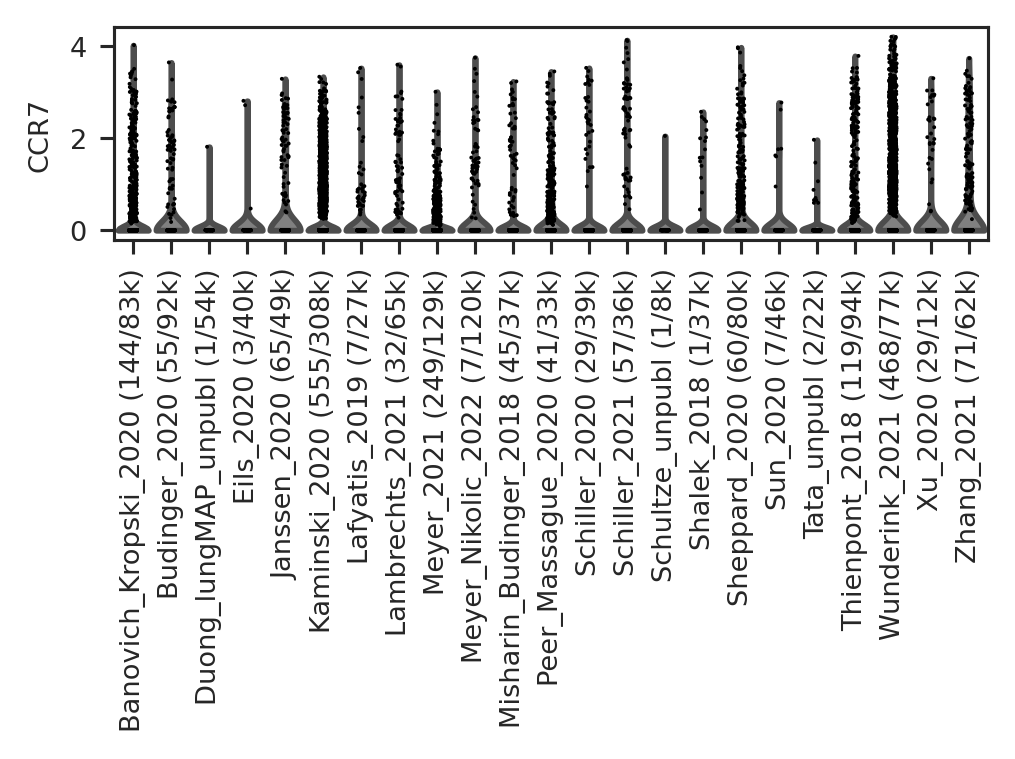

In [31]:
FIGURES["ED19_migratory_dcs_violin_extended_atlas_dcs"], ax = plt.subplots()
sc.pl.violin(
    ext_dcs_migdc_studies,
    keys="CCR7",
    groupby="Study (cell numbers)",
    palette={study: "grey" for study in ext_dcs.obs["Study (cell numbers)"].unique()},
    rotation=90,
    return_fig=True,
    ax=ax,
    vmax=4.5,
)

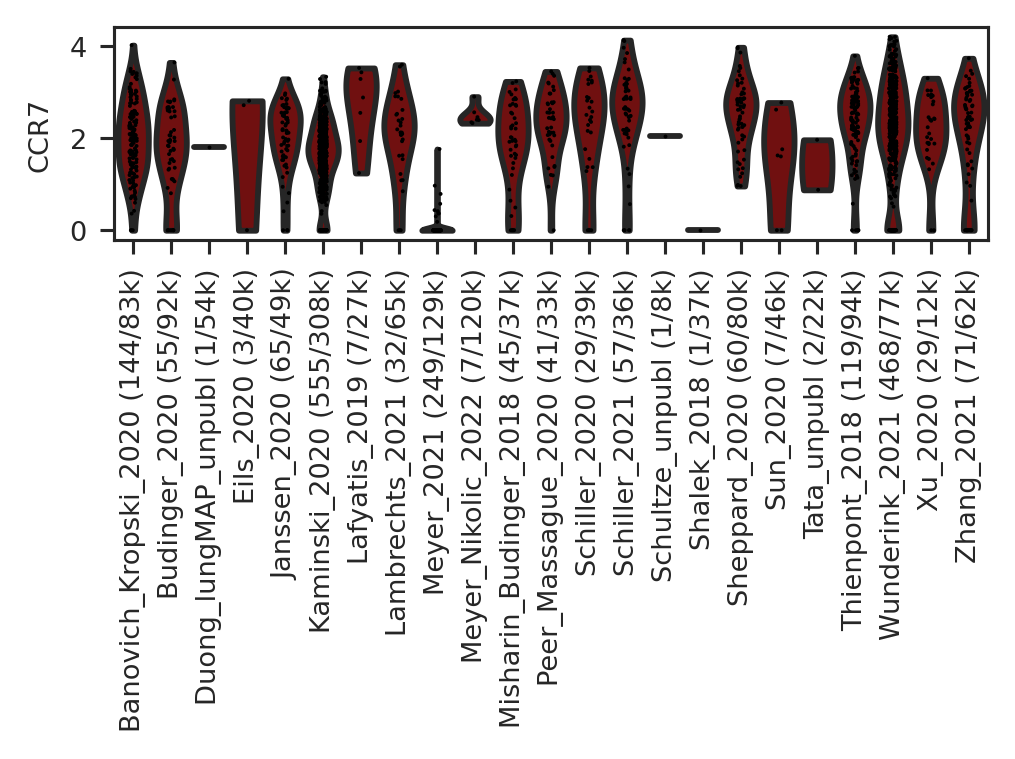

In [32]:
FIGURES["ED19_migratory_dcs_violin_extended_atlas_mdcs"], ax = plt.subplots()
sc.pl.violin(
    ext_mig_dcs,
    keys="CCR7",
    groupby="Study (cell numbers)",
    palette={
        study: "maroon" for study in ext_mig_dcs.obs["Study (cell numbers)"].unique()
    },
    rotation=90,
    return_fig=True,
    ax=ax,
    vmax=4.5,
)

### Uncertainty per cell type, per metadata category:

Determine which resolution of labels we want to use for these figures. We want to choose a resolution that is high-certainty in healthy, i.e. labels that normally transfered well. That will be a good baseline to compare the other conditions against.  
As data points, we will use per-dataset (per-celltype) means, as we want to get a feeling for how likely a dataset of a specific type is to map well to the HLCA. If we would use cells as data points, some datasets might be weighed a lot higher than others. The heatmap colors are therefore means of dataset-means!

In [33]:
min_n_cells = 20  # min n cells to take a dataset into consideration for a celltype
uncert_threshold = (
    0.25  # max uncertainty in healthy to include cell type label level in plot
)
vmax = 0.4

In [34]:
per_ds_ct_uncerts = dict()
per_ds_ct_n = dict()

add info to label transfer result dataframe:

In [35]:
for col in [
    "condition",
    "dataset",
    "single_cell_platform",
    "sample_type",
    "subject_ID",
    "sample",
    "cells_or_nuclei",
    "study",
]:
    trans[col] = ext.obs.loc[trans.index, col]

add simplified condition:

In [36]:
condition_simplifier = {cond: cond for cond in trans.condition.unique()}
condition_simplifier.update(
    {
        "COVID-19 moderate": "COVID-19",
        "COVID-19 severe": "COVID-19",
        "Healthy (tumor adjacent)": "Healthy",
        "Large Cell Carcinoma": "Carcinoma",
        "Lung adenocarcinoma": "Carcinoma",
        "Pleiomorphic Carcinoma": "Carcinoma",
        "Squamous Cell Carcinoma": "Carcinoma",
        "HP": "ILD",
        "Myositis-associated ILD": "ILD",
        "NSIP": "ILD",
        "Systemic sclerosis-associated ILD": "ILD",
    }
)
trans["condition_simpl"] = trans.condition.map(condition_simplifier)

add simplified single_cell_platform:

In [37]:
scp_simplifier = {
    "10X 3' v2": "10X 3'",
    "10X 3' v3": "10X 3'",
    "Drop-Seq": "Drop-Seq",
    "10X 5' v1": "10X 5'",
    "10X 5'": "10X 5'",
    "10X 3'": "10X 3'",
    "Seq-Well": "Seq-Well",
}
for scp in trans.single_cell_platform.unique():
    if scp not in scp_simplifier.keys():
        raise ValueError("Not all single cell platforms are included in your mapping!")
trans["scp_simpl"] = trans["single_cell_platform"].map(scp_simplifier)

subset to healthy:

In [38]:
trans_healthy = trans.loc[trans.condition_simpl == "Healthy", :].copy()

calculate uncertainty per dataset, per cell type for all levels:

In [39]:
for lev in range(1, 6):
    lev_ds_ct_uncerts = (
        trans_healthy.groupby(["dataset", f"transf_ann_level_{lev}_label"])
        .agg({f"transf_ann_level_{lev}_uncert": "mean"})
        .unstack()
    )
    lev_ds_ct_n = (
        trans_healthy.groupby(["dataset", f"transf_ann_level_{lev}_label"])
        .agg({"dataset": "count"})
        .unstack()
    )
    lev_ds_ct_uncerts.columns = lev_ds_ct_uncerts.columns.droplevel(0)
    lev_ds_ct_n.columns = lev_ds_ct_n.columns.droplevel(0)
    lev_ds_ct_uncerts.columns.name = None
    lev_ds_ct_n.columns.name = None
    per_ds_ct_uncerts[lev] = lev_ds_ct_uncerts
    per_ds_ct_n[lev] = lev_ds_ct_n.fillna(0)

now calculate mean uncertainty for every cell type:

In [40]:
ct_uncerts = dict()
for lev in range(1, 6):
    lev_ds_ct_uncerts = per_ds_ct_uncerts[lev]
    lev_ds_ct_uncerts[per_ds_ct_n[lev] < min_n_cells] = np.nan

    ct_uncerts[lev] = lev_ds_ct_uncerts.mean(axis=0, skipna=True).fillna(0)

For every celltype, check if it and its sister types from the same clade are all low uncertainty

In [41]:
ct_status = dict()
for lev in range(2, 6):
    lev_cts = ct_df[f"Level_{lev}"].unique()
    lev_ct_status = pd.Series(index=lev_cts, dtype="object")
    for ct in lev_cts:
        # get parent celltype
        parent_lev = lev - 1
        parent_ct = set(ct_df.loc[ct_df[f"Level_{lev}"] == ct, f"Level_{parent_lev}"])
        if len(parent_ct) > 1:
            raise ValueError("Celltype {ct} has multiple parents, something is wrong!")
        else:
            parent_ct = list(parent_ct)[0]
        # get sister types of the cell type (including itself)
        sister_cts = list(
            set(ct_df.loc[ct_df[f"Level_{parent_lev}"] == parent_ct, f"Level_{lev}"])
        )
        # if all this celltype's sistertypes are low uncertainty, we set the celltype to True
        lev_ct_status[ct] = (ct_uncerts[lev].loc[sister_cts] <= uncert_threshold).all()
    ct_status[lev] = lev_ct_status

Now loop through finest cell type labels, and fall back to higher level where necessary:

In [42]:
fine_ct_to_certain_ct = dict()
fine_ct_to_certain_lev = dict()
for ct in ct_df.index:
    ct_lev5_label = ct_df.loc[ct, "Level_5"]
    status = True
    # start at level 1
    lev = 1
    # check at which clade level we reach high uncertainty for the first time
    while status == True:
        lev += 1
        if lev == 6:
            # we have checked all levels, exit loop
            status = False
        else:
            # get label of the cell type at this level
            ct_lev_label = ct_df.loc[ct, f"Level_{lev}"]
            # get status (does label at this level pass certainty conditions)
            ct_lev_status = ct_status[lev][ct_lev_label]
            # set status as such (to stop loop if we get to False)
            status = ct_lev_status
    # take the cell type label from within the high-certainty clade
    certain_level = lev - 1
    if certain_level == 0:
        certain_level = 1
    fine_ct_to_certain_ct[ct_lev5_label] = ct_df.loc[ct, f"Level_{certain_level}"]
    fine_ct_to_certain_lev[ct_lev5_label] = certain_level

Print figure labels that differ from level 5 labels:

In [43]:
for detailed, coarsified in fine_ct_to_certain_ct.items():
    if detailed != coarsified:
        if coarsified[1] == "_":
            coarsified_clean = coarsified[2:]
        else:
            coarsified_clean = coarsified
        if detailed[1] == "_":
            detailed_clean = detailed[2:]
        else:
            detailed_clean = detailed
        if detailed != coarsified_clean and detailed_clean != coarsified:
            print(f"{detailed} - {coarsified}")

4_Basal resting - Basal
4_Suprabasal - Basal
4_Hillock-like - Basal
Multiciliated (nasal) - Multiciliated
Multiciliated (non-nasal) - Multiciliated
Club (non-nasal) - Secretory
Club (nasal) - Secretory
Goblet (nasal) - Secretory
Goblet (bronchial) - Secretory
Goblet (subsegmental) - Secretory
AT0 - Secretory
pre-TB secretory - Secretory
4_Ionocyte - Rare
4_Tuft - Rare
4_Neuroendocrine - Rare
SMG serous (nasal) - Submucosal Secretory
SMG serous (bronchial) - Submucosal Secretory
4_SMG mucous - Submucosal Secretory
4_SMG duct - Submucosal Secretory
4_EC venous systemic - EC venous
4_EC venous pulmonary - EC venous
4_Peribronchial fibroblasts - Fibroblast lineage
4_Adventitial fibroblasts - Fibroblast lineage
4_Alveolar fibroblasts - Fibroblast lineage
4_Pericytes - Fibroblast lineage
4_Subpleural fibroblasts - Fibroblast lineage
3_Myofibroblasts - Fibroblast lineage
3_Fibromyocytes - Smooth muscle
3_SM activated stress response - Smooth muscle
4_Alveolar macrophages - Macrophages
Alveola

Store resulting info in our label transfer df:

In [44]:
trans["transf_label_for_figures"] = trans.transf_ann_level_5_label.map(
    fine_ct_to_certain_ct
)
trans["transf_level_for_figures"] = trans.transf_ann_level_5_label.map(
    fine_ct_to_certain_lev
)
trans["transf_uncert_for_figures"] = [
    trans.loc[cell, f"transf_ann_level_{lev}_uncert"]
    for cell, lev in zip(trans.index, trans.transf_level_for_figures)
]

Get set of new labels, in biological order for plotting:

In [45]:
figure_labels_ordered_incl_dupl = ct_df.Level_5.map(fine_ct_to_certain_ct).values
figure_labels_ordered = list()
for lab in figure_labels_ordered_incl_dupl:
    if lab not in figure_labels_ordered:
        figure_labels_ordered.append(lab)

Calculate the baseline uncertainty for every cell type.  
Option 1: take all healthy as baseline (this will still include datasets with higher uncertainty due to e.g. single nucleus, autopsy samples etc.).   
Option 2: take the most common experimental settings from the core, i.e. 3', donor lung, cells

In [46]:
baseline_option = 1

In [47]:
if baseline_option == 1:
    trans_baseline = trans.loc[
        [cond == "Healthy" for cond in trans.condition_simpl],
        :,
    ].copy()
elif baseline_option == 2:
    trans_baseline = trans.loc[
        [
            cond == "Healthy"
            and scp == "10X 3'"
            and st == "donor_lung"
            and cn == "cells"
            for cond, scp, st, cn in zip(
                trans.condition_simpl,
                trans.scp_simpl,
                trans.sample_type,
                trans.cells_or_nuclei,
            )
        ],
        :,
    ].copy()
else:
    raise ValueError("baseline option should be set to either 1 or 2!")

In [48]:
baseline_ct_ds_uncert = (
    trans_baseline.groupby(["dataset", "transf_label_for_figures"])
    .agg({"transf_uncert_for_figures": "mean"})
    .unstack()
).droplevel(0, axis=1)
baseline_ct_ds_n = (
    trans_baseline.groupby(["dataset", "transf_label_for_figures"])
    .agg({"transf_label_for_figures": "count"})
    .unstack()
).droplevel(0, axis=1)
if baseline_option == 1:
    baseline_ct_ds_uncert_unfilt = baseline_ct_ds_uncert.copy()
    baseline_ct_ds_uncert[baseline_ct_ds_n < min_n_cells] = np.nan
# For option 2 we won't filter on minimum number of cells, since then we'll end up without data for many cell types

check what number of cell types are not represented in the baseline (if this is >0, think of a solution...)

In [49]:
healthy_baseline = baseline_ct_ds_uncert.mean(axis=0, skipna=True)
print("Number of cell types without baseline:")
if baseline_option == 1:
    n_cts_wo_baseline = ((baseline_ct_ds_n > min_n_cells).sum(axis=0) == 0).sum()
elif baseline_option == 2:
    n_cts_wo_baseline = ((baseline_ct_ds_n > 0).sum(axis=0) == 0).sum()
print(n_cts_wo_baseline)
if baseline_option == 1:
    cts_wo_baseline = list(
        baseline_ct_ds_n.columns[(baseline_ct_ds_n > min_n_cells).sum(axis=0) == 0]
    )
    print(cts_wo_baseline)
    print("Using unfiltered data for baseline for these celltypes.")
    healthy_baseline[cts_wo_baseline] = baseline_ct_ds_uncert_unfilt.loc[
        :, cts_wo_baseline
    ].mean(axis=0, skipna=True)

Number of cell types without baseline:
2
['2_Hematopoietic stem cells', '3_Lymphatic EC proliferating']
Using unfiltered data for baseline for these celltypes.


Specify which values/categories to include for every variable (only those that are included in figure, i.e. that are in at least 2 datasets):

In [51]:
min_n_datasets = 2
min_n_studies = 2
groups_to_include = dict()
for cat in [
    "condition_simpl",
    "scp_simpl",
    "sample_type",
    "cells_or_nuclei",
]:
    ds_st_count = trans.groupby(cat).agg({"dataset": "nunique", "study": "nunique"})
    groups_to_include[cat] = ds_st_count.loc[
        [
            suff_ds and suff_st
            for suff_ds, suff_st in zip(
                ds_st_count.dataset >= min_n_datasets,
                ds_st_count.study >= min_n_studies,
            )
        ],
        :,
    ].index.tolist()

Now plot uncertainties per cell type, per dataset. These figures are not included in the paper, but could be useful when wanting to inspect consistency/variance across datasets from the same category:

In [52]:
cov = "condition_simpl"
cov2 = "sample_type"

trans_fig = trans.loc[trans[cov].isin(groups_to_include[cov]), :].copy()
# create a variable containing both cov and dataset info
trans_fig["cov_ds"] = [
    f"{cat1}_{cat2}_{ds}"
    for cat1, cat2, ds in zip(trans_fig[cov], trans_fig[cov2], trans_fig.dataset)
]
# group by that variable
uncert_ct_cov_ds = (
    trans_fig.groupby(["cov_ds", "transf_label_for_figures"])
    .agg({"transf_uncert_for_figures": "mean"})
    .unstack()
    .droplevel(0, axis=1)
)
# count number of cells per ds/cov, per cell type:
count_ct_cov_ds = (
    trans_fig.groupby(["cov_ds", "transf_label_for_figures"])
    .agg({"transf_label_for_figures": "count"})
    .unstack()
    .droplevel(0, axis=1)
)
# set ds_cov ct pairs with fewer than min_n_cells to NA
min_n_cells = 20
uncert_ct_cov_ds[count_ct_cov_ds < min_n_cells] = None

In [53]:
custom_cmap = copy.copy(cm.get_cmap("Reds"))  # select color map
custom_cmap.set_bad("grey")  # set masked color to grey instead of white
custom_cmap_2 = copy.copy(cm.get_cmap("coolwarm"))
custom_cmap_2.set_bad("grey")  # set masked color to grey instead of white

In [54]:
def plot_ct_uncert_per_dataset_cov_comb(
    trans, cov, cov2=None, min_n_cells=50, vmax=0.4, healthy_baseline=None
):
    # subset to condition groups included in figure 6b
    trans_fig = trans.loc[trans[cov].isin(groups_to_include[cov]), :].copy()
    # create a variable containing both cov and dataset info
    if pd.isnull(cov2):
        trans_fig["cov_ds"] = [
            f"{cat}_{ds}" for cat, ds in zip(trans_fig[cov], trans_fig.dataset)
        ]
    else:
        trans_fig["cov_ds"] = [
            f"{cat1}_{cat2}_{ds}"
            for cat1, cat2, ds in zip(
                trans_fig[cov], trans_fig[cov2], trans_fig.dataset
            )
        ]
    # group by that variable
    uncert_ct_cov_ds = (
        trans_fig.groupby(["cov_ds", "transf_label_for_figures"])
        .agg({"transf_uncert_for_figures": "mean"})
        .unstack()
        .droplevel(0, axis=1)
    )
    # count number of cells per ds/cov, per cell type:
    count_ct_cov_ds = (
        trans_fig.groupby(["cov_ds", "transf_label_for_figures"])
        .agg({"transf_label_for_figures": "count"})
        .unstack()
        .droplevel(0, axis=1)
    )
    # set ds_cov ct pairs with fewer than min_n_cells to NA
    uncert_ct_cov_ds[count_ct_cov_ds < min_n_cells] = None
    # remove datasets not in extension:
    uncert_ct_cov_ds.dropna(axis=0, how="all", inplace=True)
    # sort cts biologically
    uncert_ct_cov_ds = uncert_ct_cov_ds.loc[:, figure_labels_ordered].copy()
    # clean cell type names:
    uncert_ct_cov_ds.columns = [
        col[2:] if col[1] == "_" else col for col in uncert_ct_cov_ds.columns
    ]
    # set mask to all values that have NA
    mask = pd.isnull(uncert_ct_cov_ds)
    # generate a color dictionary for row colors:
    cond_to_col_dict = dict()
    n_cats = len(groups_to_include[cov])
    colors = cm.tab10(np.linspace(0, 1, n_cats))
    color_dict = dict(zip(groups_to_include[cov], colors))
    cov_ds_to_color = dict()
    for cov_ds in uncert_ct_cov_ds.index:
        for cat in groups_to_include[cov]:
            if cov_ds.startswith(cat):
                cov_ds_to_color[cov_ds] = color_dict[cat]
    # plot
    fig = sns.clustermap(
        uncert_ct_cov_ds.fillna(0),  # set NAs to zero, they will be masked anyway
        mask=mask,
        figsize=(uncert_ct_cov_ds.shape[1] / 4, uncert_ct_cov_ds.shape[0] / 4),
        col_cluster=False,
        row_cluster=False,
        cmap=custom_cmap,
        row_colors=[cov_ds_to_color[cov_ds] for cov_ds in uncert_ct_cov_ds.index],
        vmax=vmax,
        vmin=0,
    )
    plt.show()
    plt.close()
    return fig

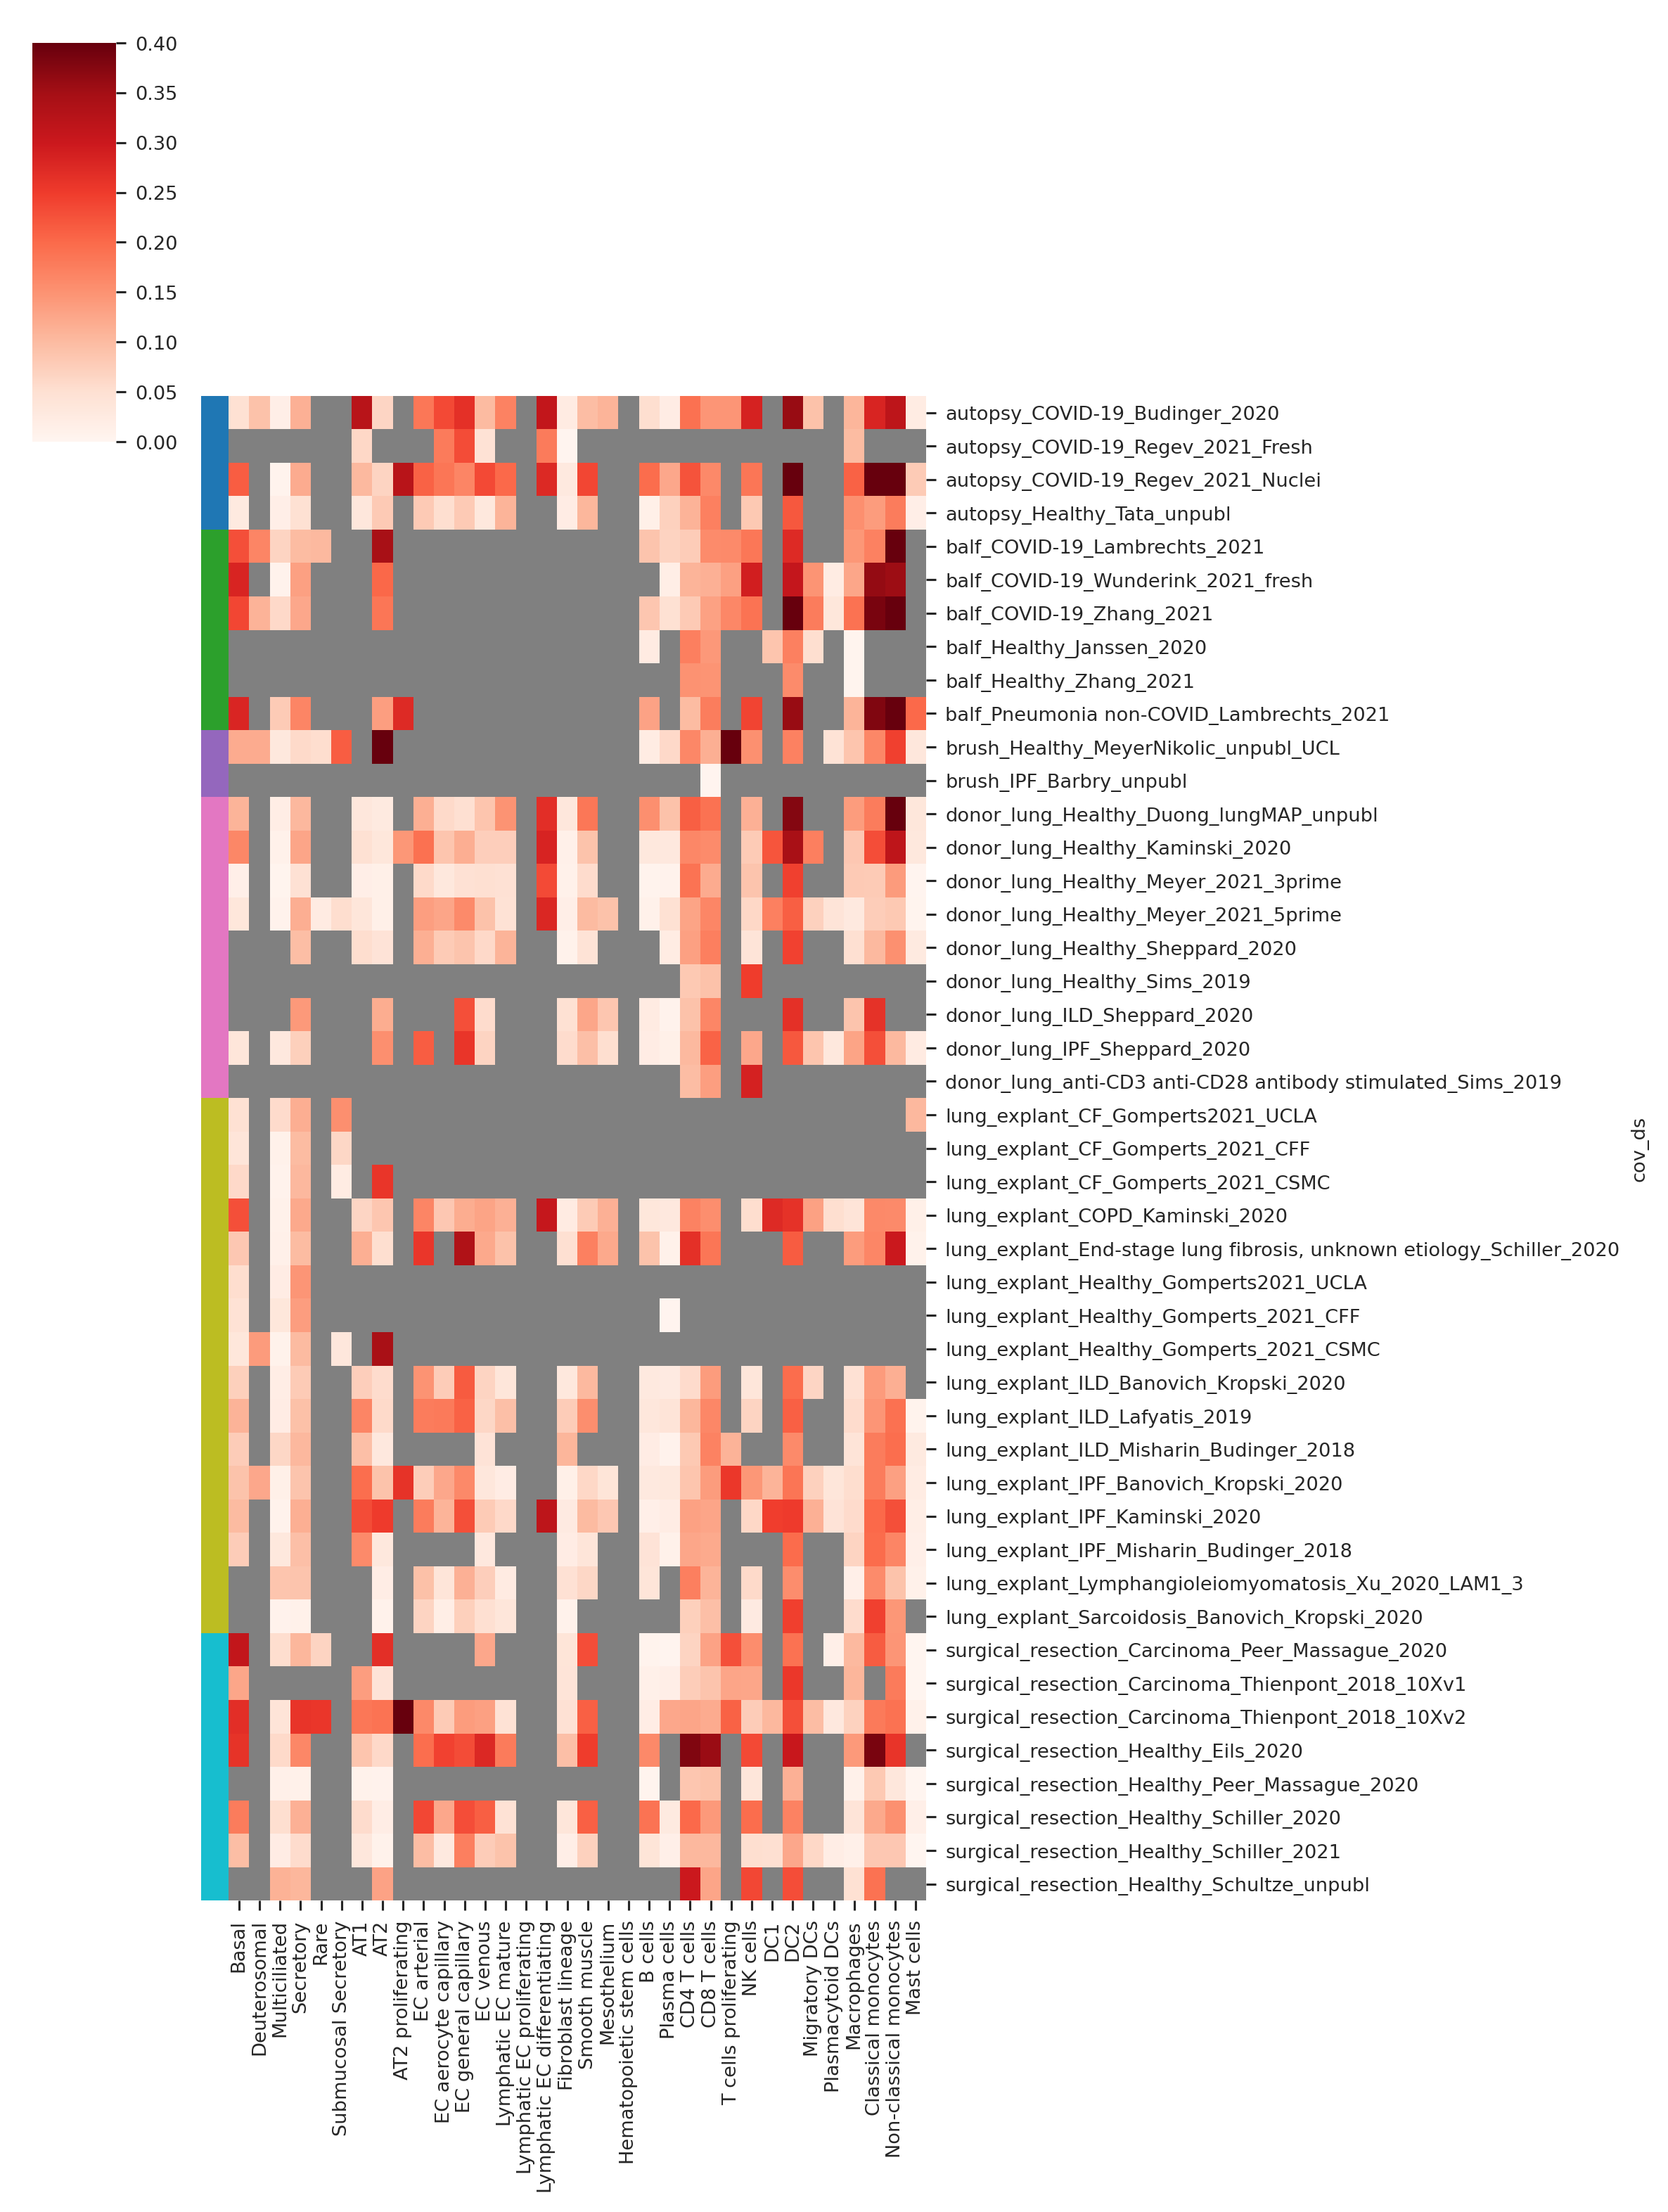

In [55]:
plot_ct_uncert_per_dataset_cov_comb(trans, "sample_type", "condition_simpl", vmax=vmax)

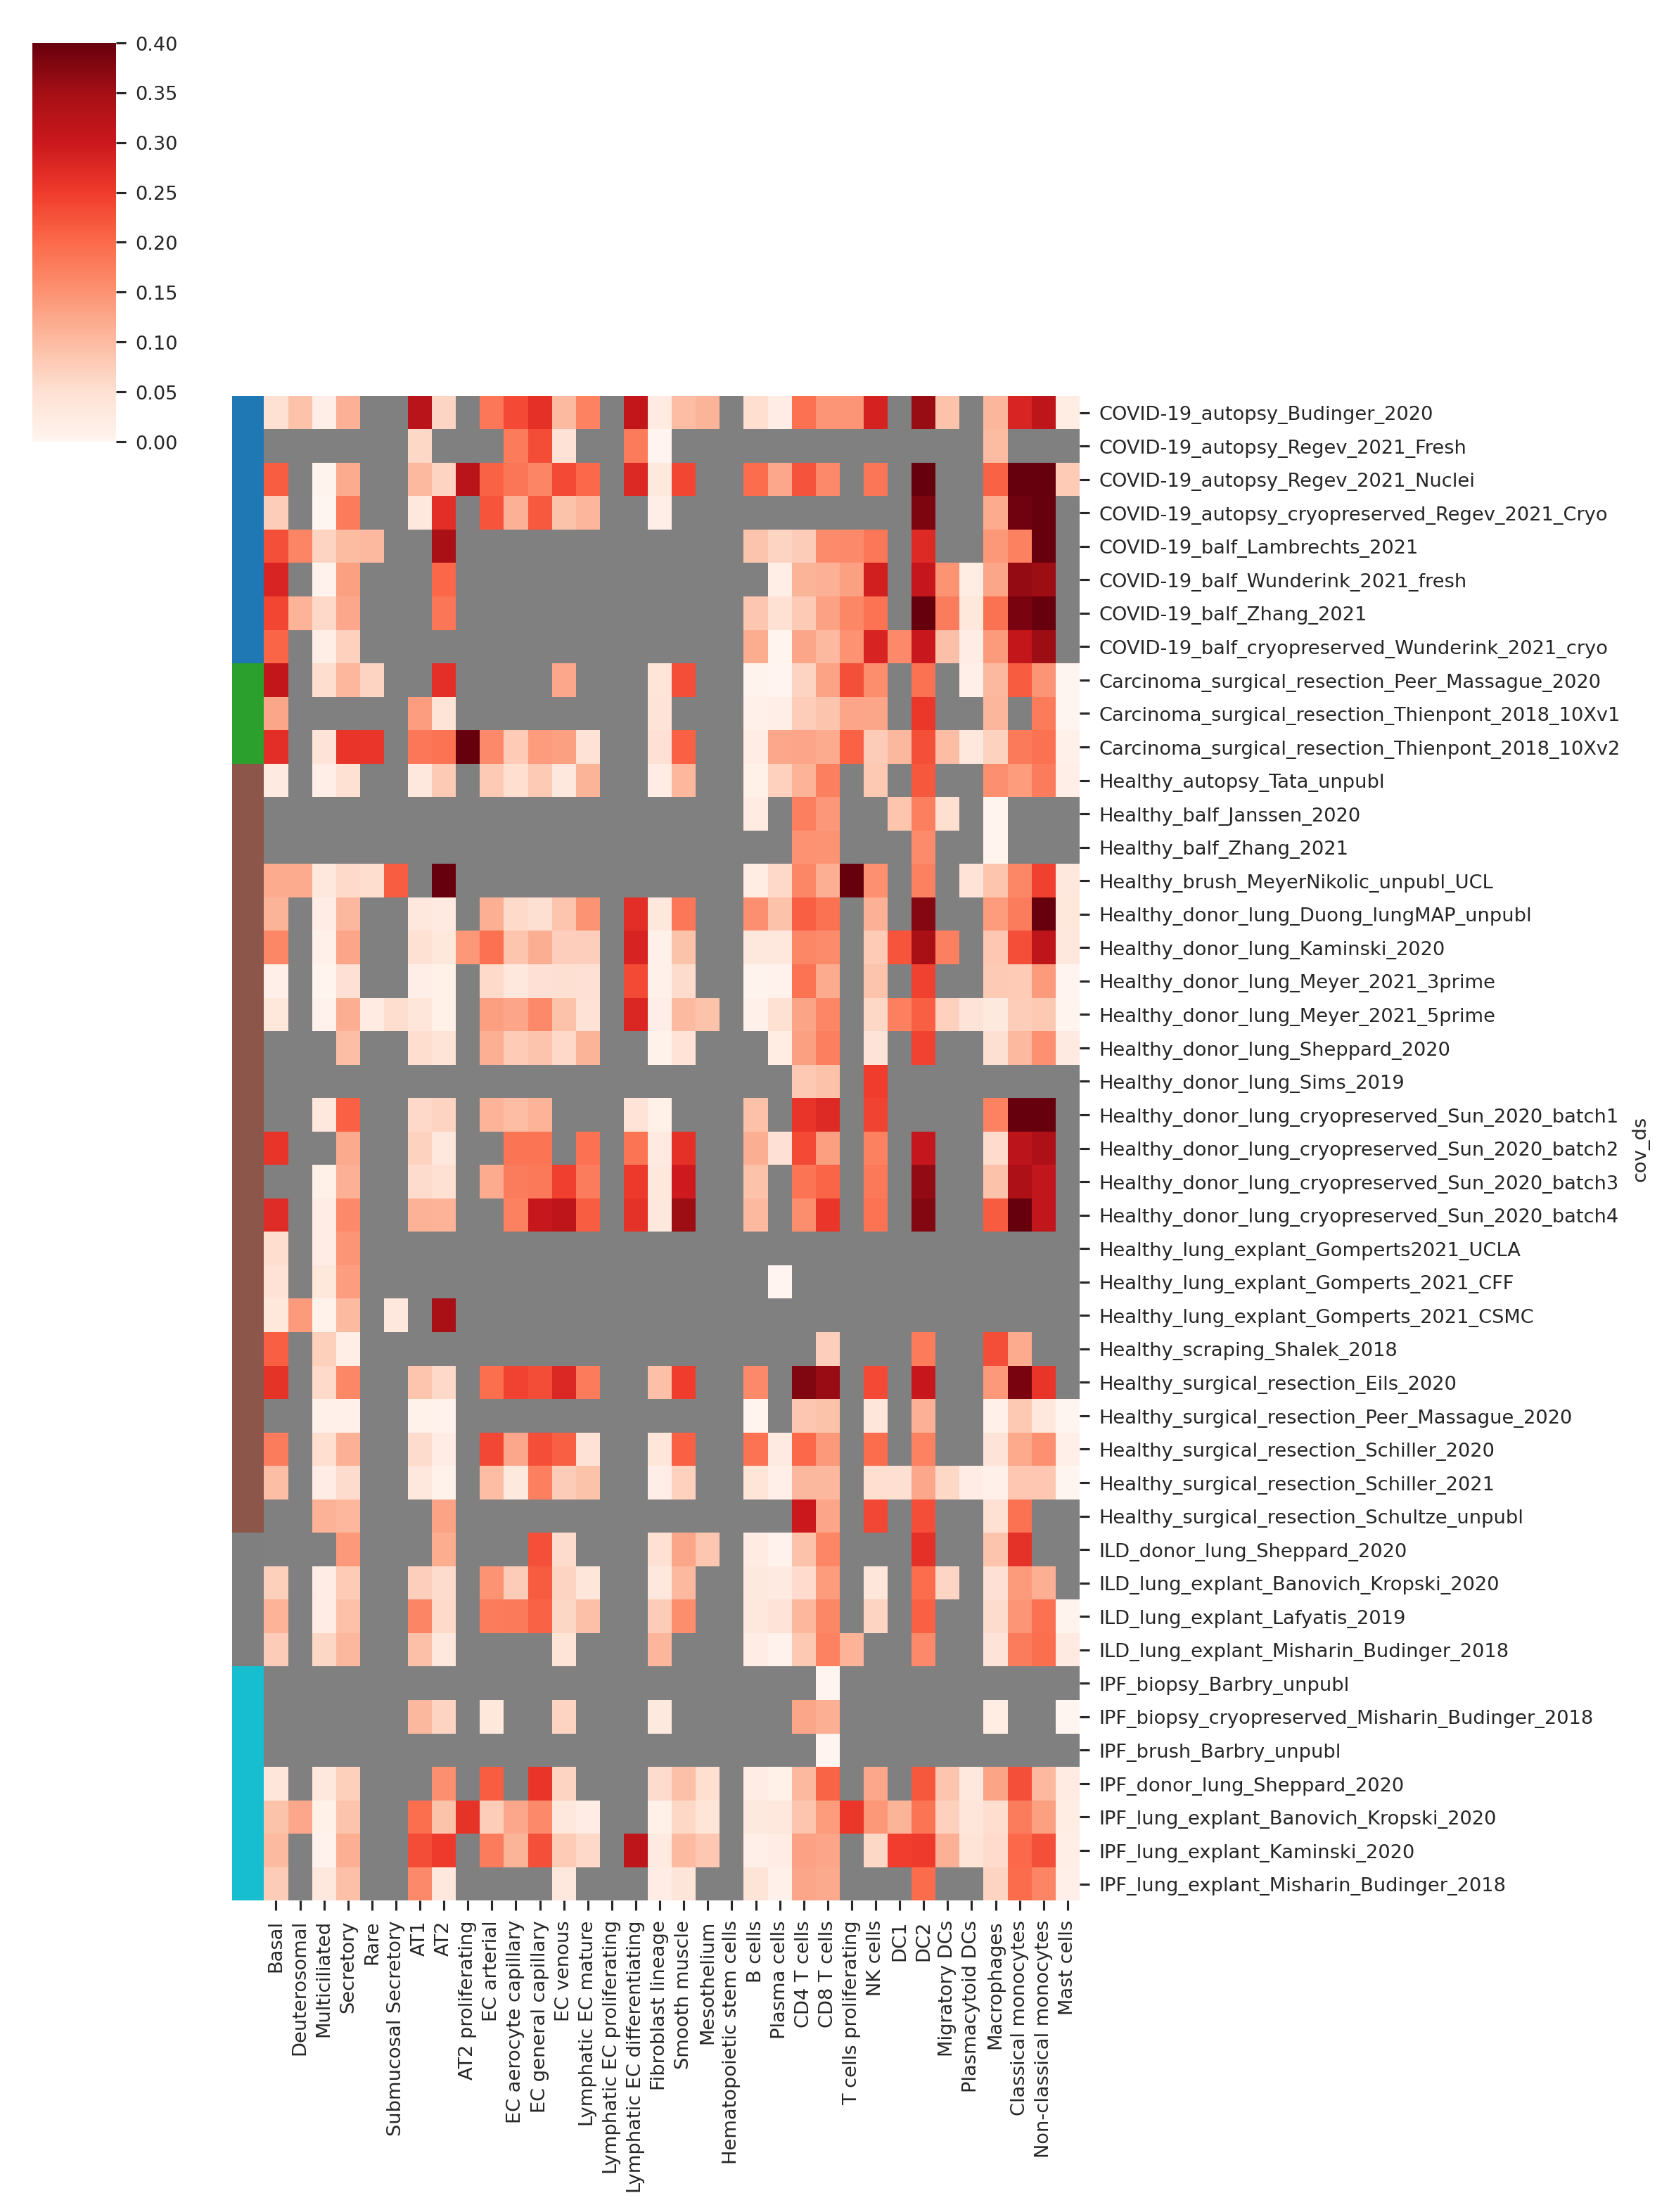

In [56]:
plot_ct_uncert_per_dataset_cov_comb(trans, "condition_simpl", "sample_type", vmax=vmax)

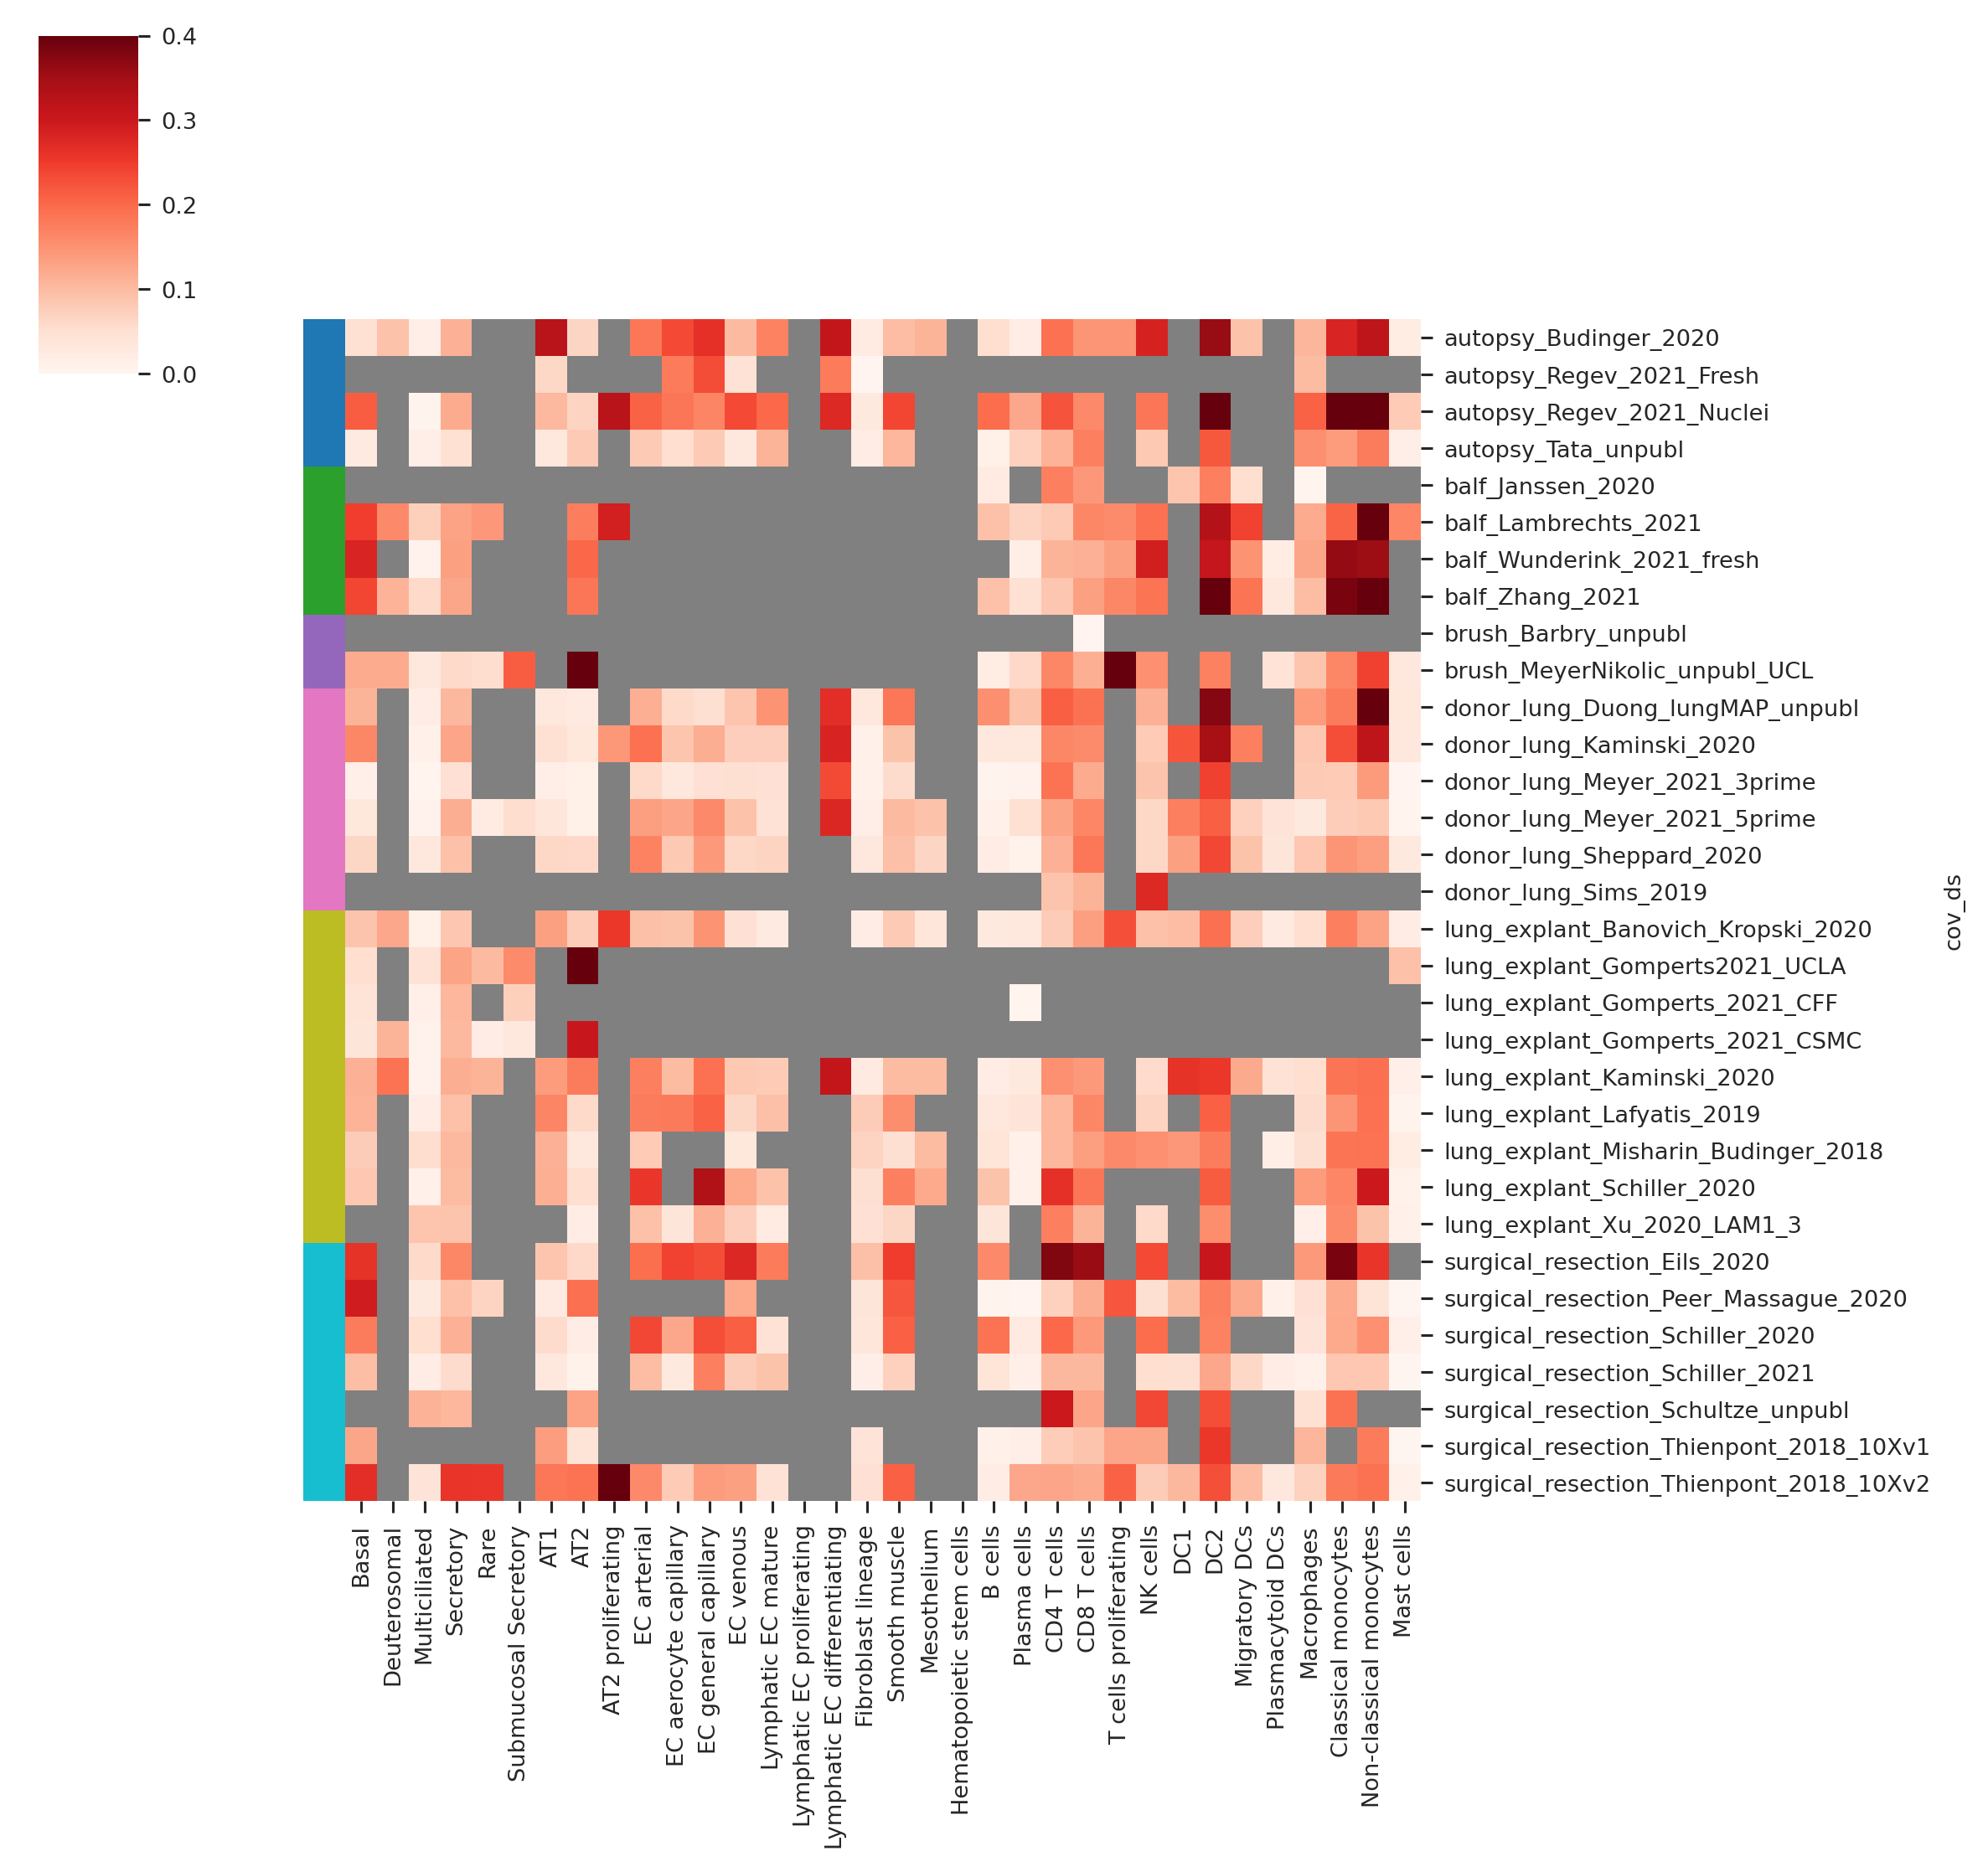

In [57]:
plot_ct_uncert_per_dataset_cov_comb(trans, "sample_type", vmax=vmax)

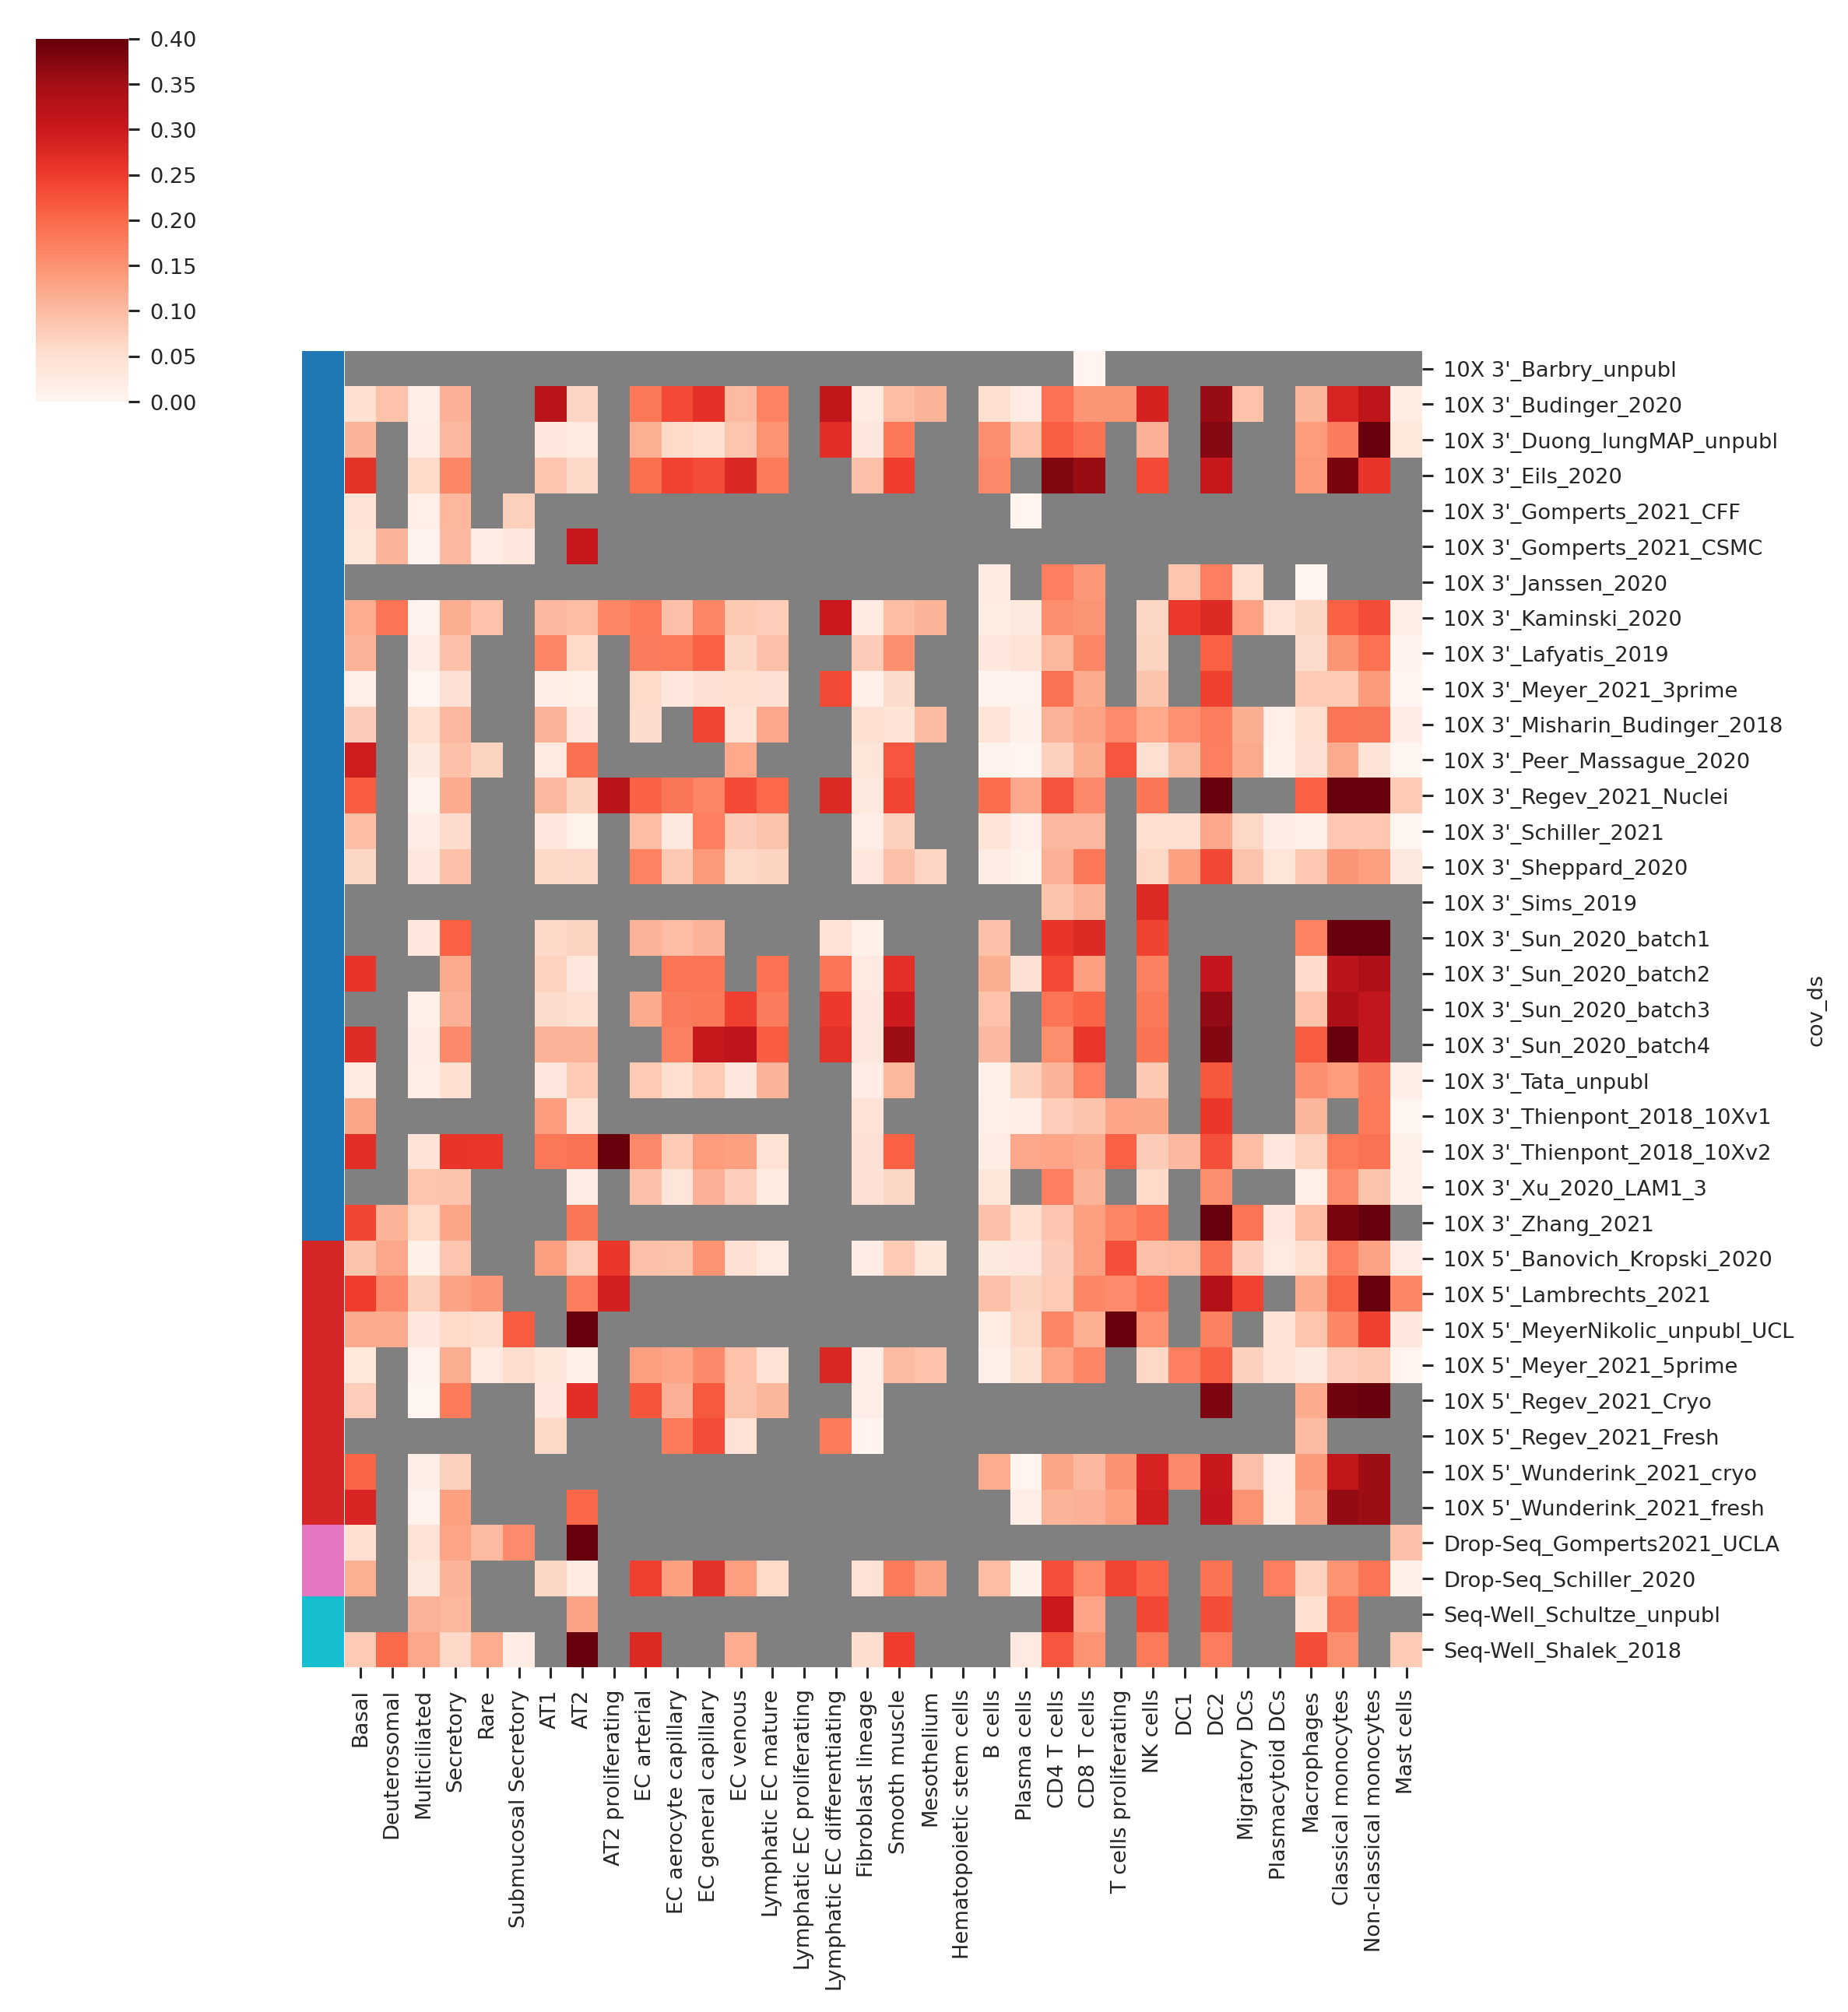

In [58]:
plot_ct_uncert_per_dataset_cov_comb(trans, "scp_simpl", vmax=vmax)

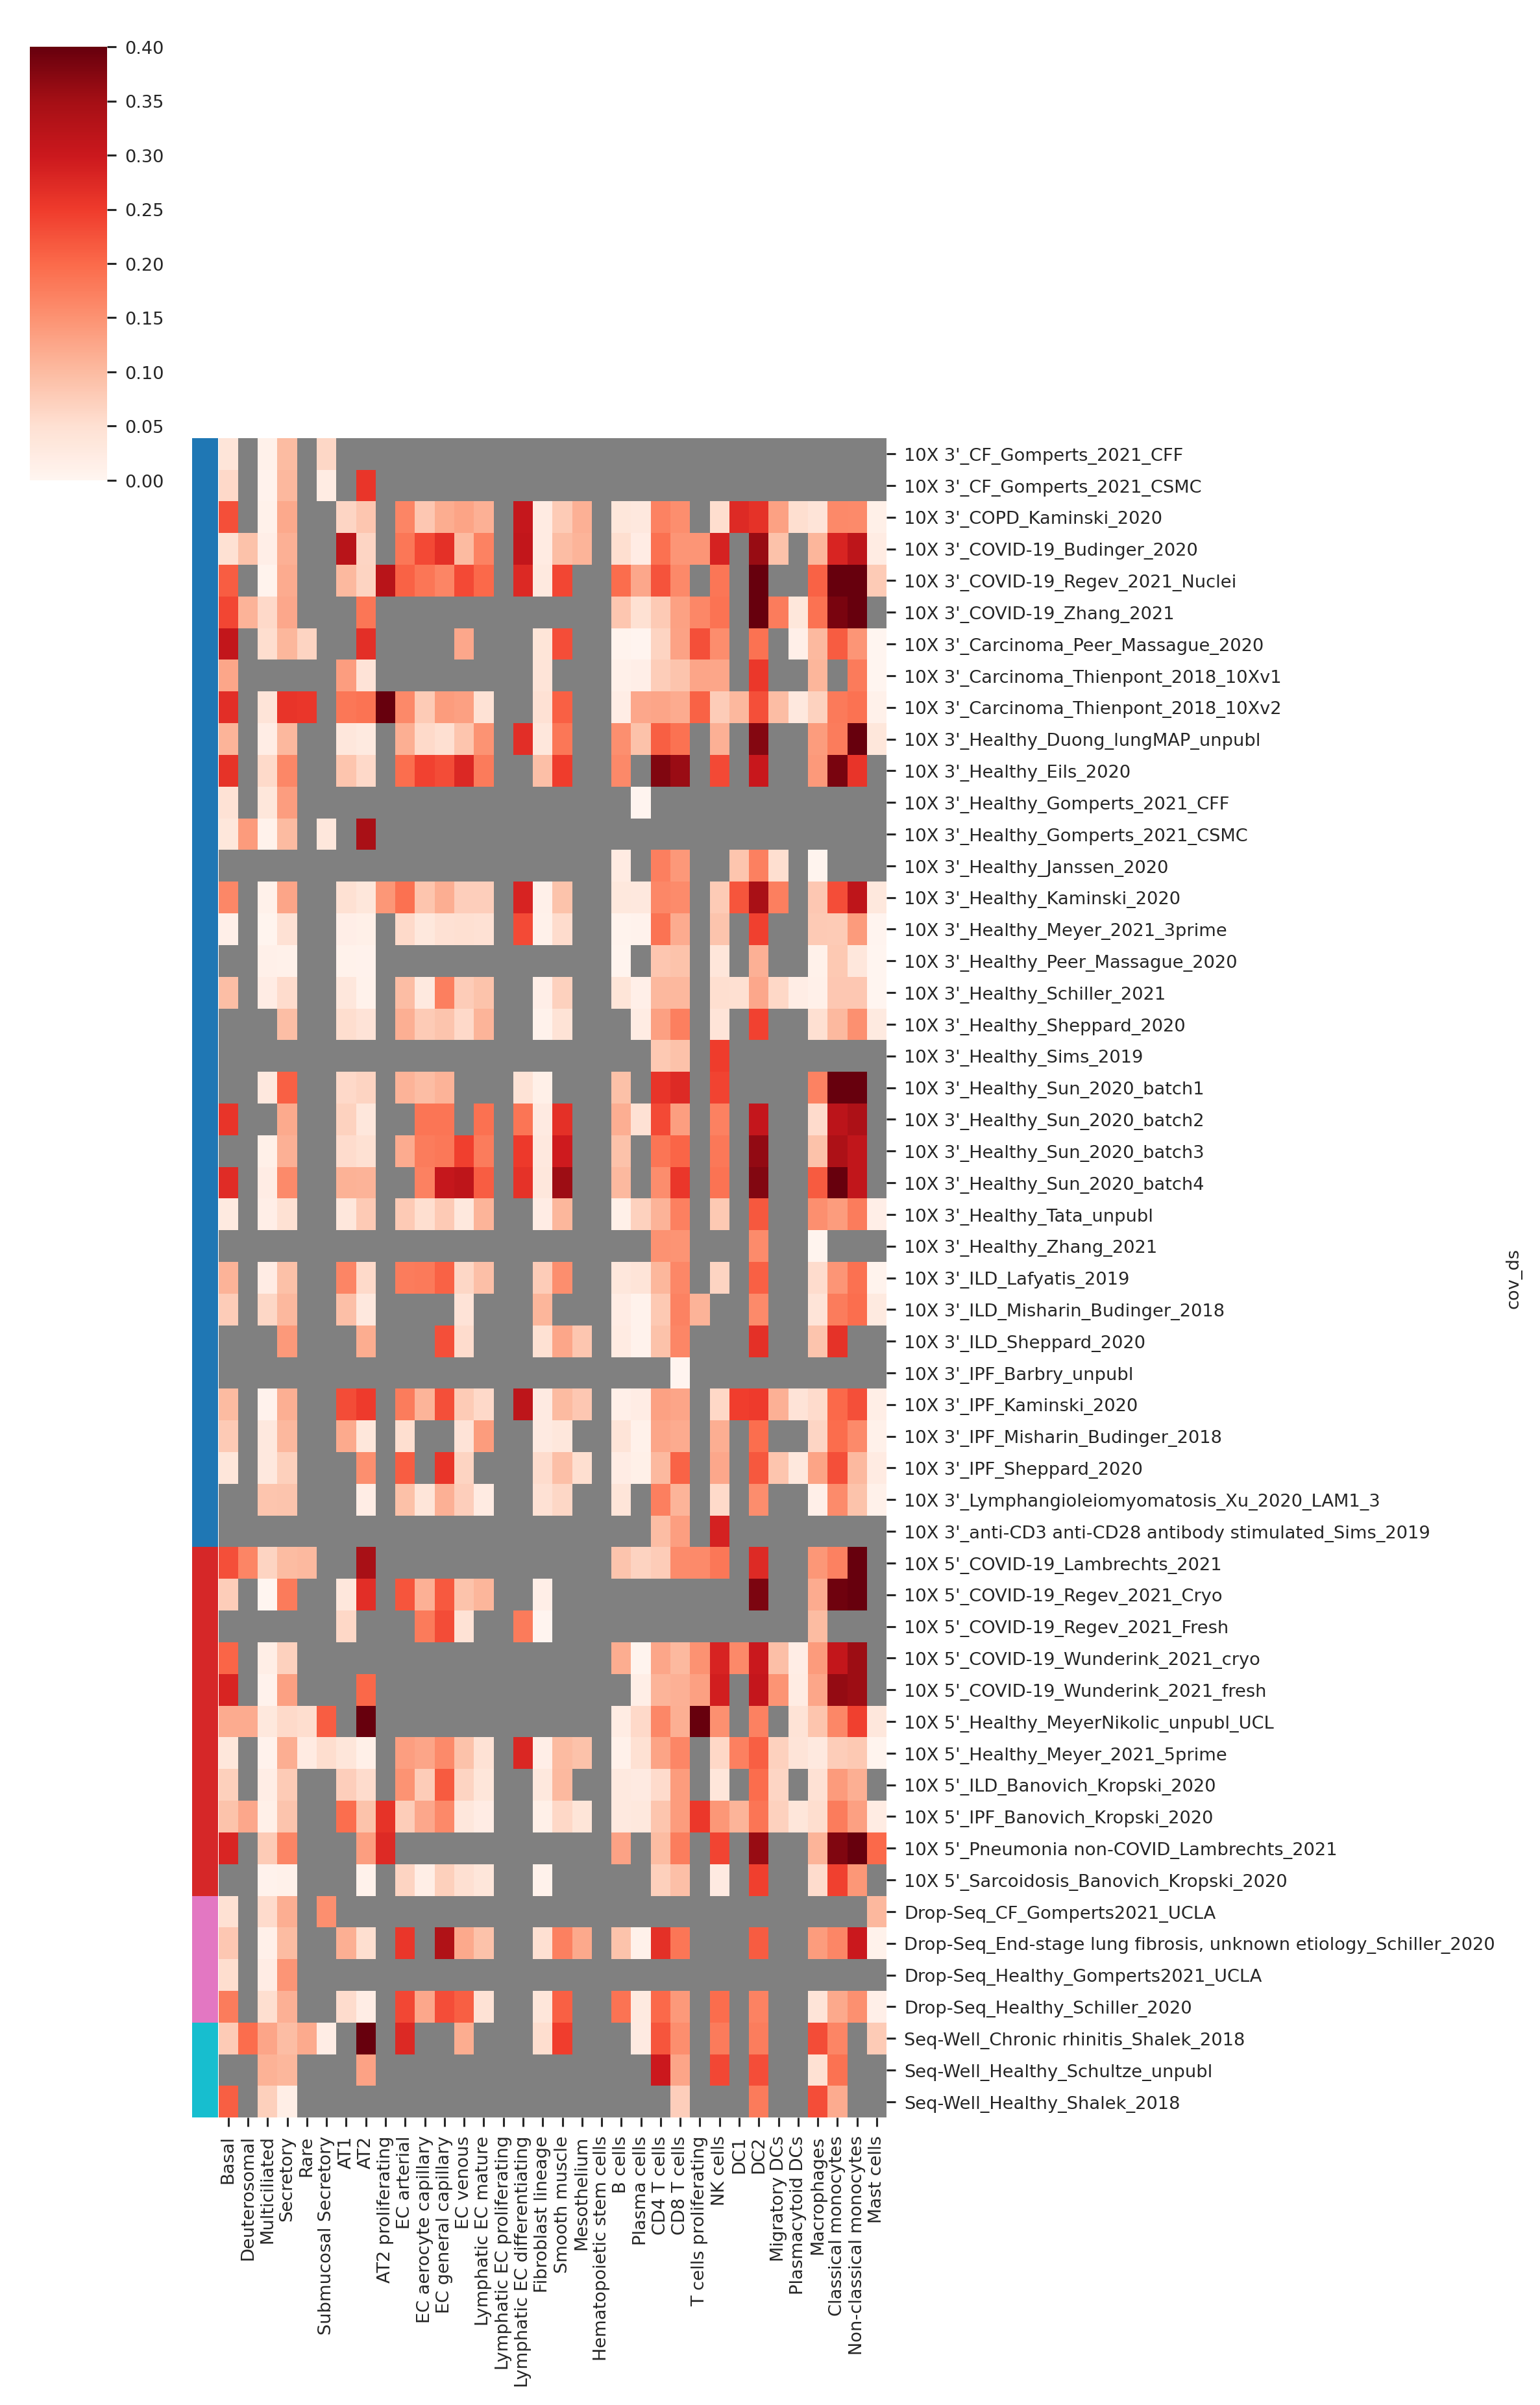

In [59]:
plot_ct_uncert_per_dataset_cov_comb(trans, "scp_simpl", "condition_simpl", vmax=vmax)

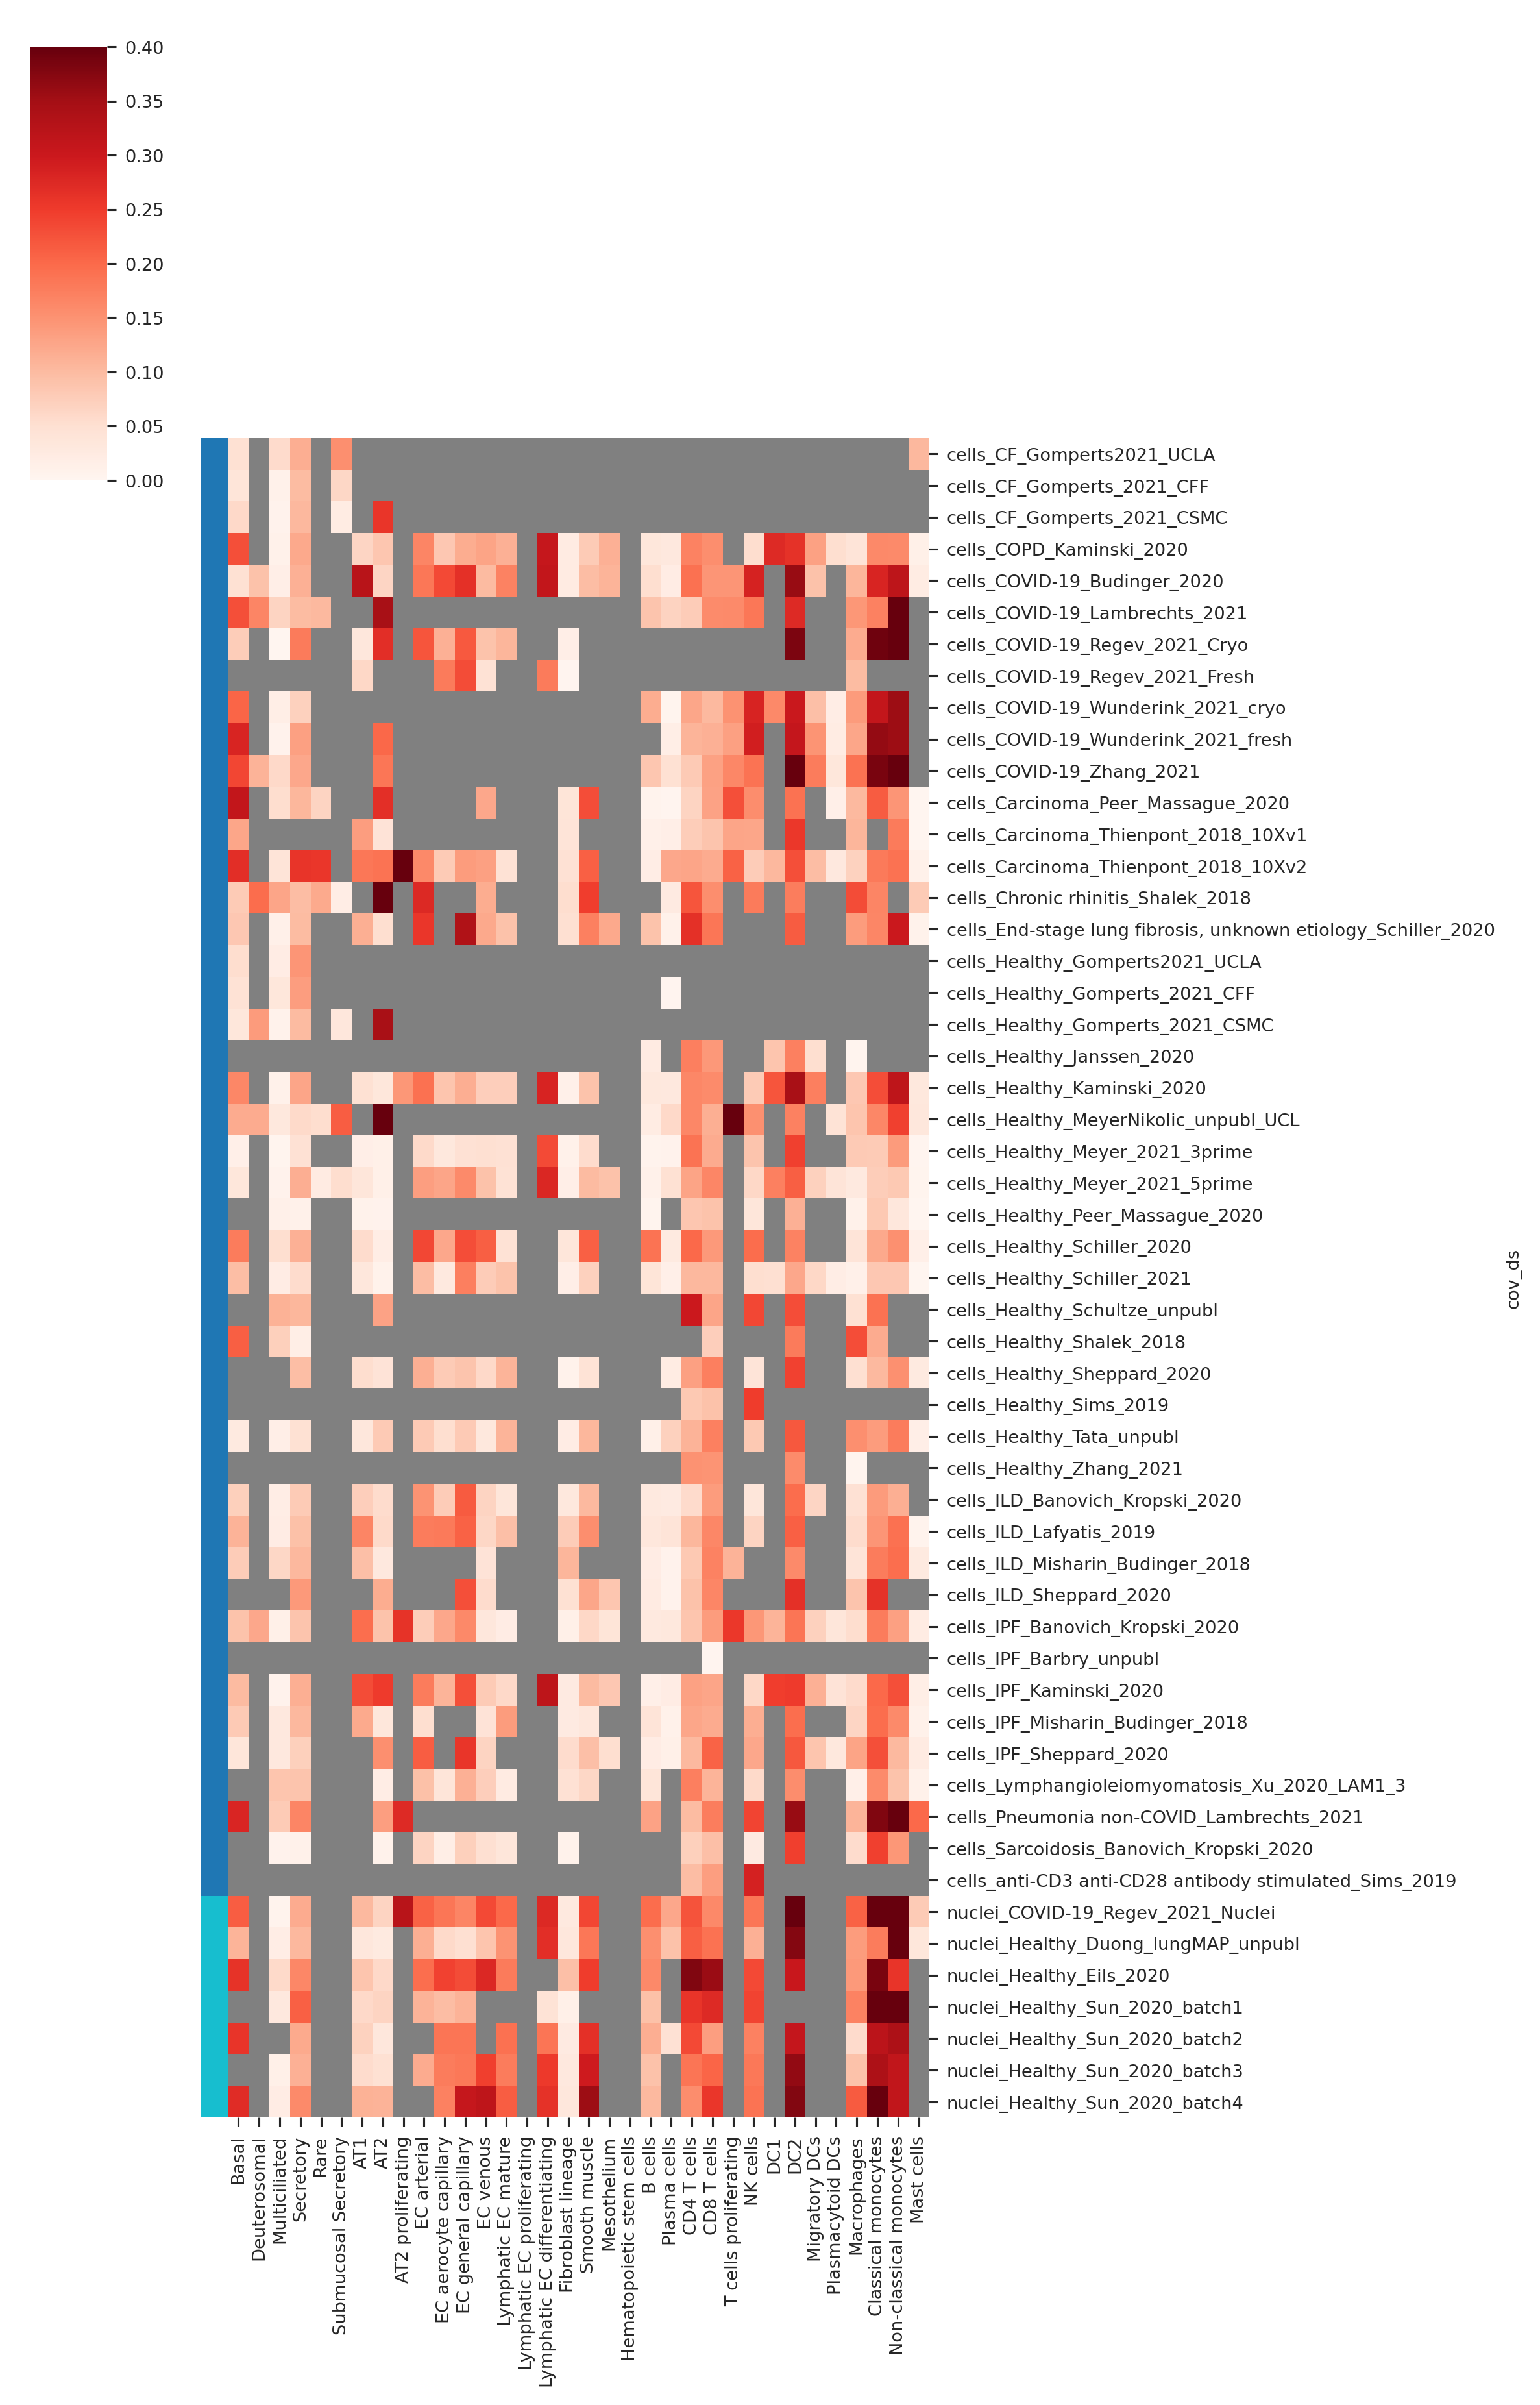

In [60]:
plot_ct_uncert_per_dataset_cov_comb(trans, "cells_or_nuclei", "condition_simpl")

Now collapse datasets from the same categories. These figures are included in the paper. We subtract uncertainties from healthy samples, of the same cell type, to see to what extent label transfer is "extra" uncertain in alternative conditions:

In [61]:
def plot_ct_uncert_per_cov(
    trans,
    cov,
    groups_to_include,
    min_n_cells=20,
    min_n_dataset=3,
    vmax=0.4,
    healthy_baseline=None,
    row_scaler=1,
):
    # subset to condition groups included in figure 6b
    trans_fig = trans.loc[trans[cov].isin(groups_to_include[cov]), :].copy()
    # create a variable containing both cov and dataset info
    trans_fig["cov_ds"] = [
        f"{cat}_{ds}" for cat, ds in zip(trans_fig[cov], trans_fig.dataset)
    ]
    # group by that variable
    uncert_ct_cov_ds = (
        trans_fig.groupby(["cov_ds", "transf_label_for_figures"])
        .agg({"transf_uncert_for_figures": "mean"})
        .unstack()
        .droplevel(0, axis=1)
    )
    # count number of cells per ds/cov, per cell type:
    count_ct_cov_ds = (
        trans_fig.groupby(["cov_ds", "transf_label_for_figures"])
        .agg({"transf_label_for_figures": "count"})
        .unstack()
        .droplevel(0, axis=1)
    )
    # set ds_cov ct pairs with fewer than min_n_cells to NA
    uncert_ct_cov_ds[count_ct_cov_ds < min_n_cells] = None
    # get cov per cov_ds pair
    cov_cats = trans_fig.groupby(["cov_ds"]).agg({cov: "first"})
    # remove datasets not in extension:
    uncert_ct_cov_ds.dropna(axis=0, how="all", inplace=True)
    # sort cts biologically
    uncert_ct_cov_ds = uncert_ct_cov_ds.loc[:, figure_labels_ordered].copy()

    # add cov cat information, then group by those cats:
    uncert_ct_cov_ds[cov] = cov_cats.loc[uncert_ct_cov_ds.index, cov]
    uncert_ct_cov = uncert_ct_cov_ds.groupby(cov).agg(
        {ct: "mean" for ct in figure_labels_ordered if ct in uncert_ct_cov_ds.columns}
    )
    # in parallel, check for every cov cat by how many datasets it is
    # represented, for every cell type
    uncert_ct_cov_ds_isnotnull = ~pd.isnull(uncert_ct_cov_ds)
    uncert_ct_cov_ds_isnotnull[cov] = uncert_ct_cov_ds[cov]
    uncert_ct_cov_ds_nds = uncert_ct_cov_ds_isnotnull.groupby(cov).agg(
        {ct: sum for ct in uncert_ct_cov_ds.columns if ct != cov}
    )
    uncert_ct_cov_ds_dsmask = uncert_ct_cov_ds_nds < min_n_dataset
    # generate a color dictionary for row colors:
    cond_to_col_dict = dict()
    n_cats = len(groups_to_include[cov])
    colors = cm.tab10(np.linspace(0, 1, n_cats))
    color_dict = dict(zip(groups_to_include[cov], colors))
    cov_ds_to_color = dict()
    for cov_ds in uncert_ct_cov.index:
        for cat in groups_to_include[cov]:
            if cov_ds.startswith(cat):
                cov_ds_to_color[cov_ds] = color_dict[cat]
    # clean row names (remove underscores, ensure the first letter is capitalized)
    uncert_ct_cov_clean = uncert_ct_cov.copy()

    def index_cleaner(idx):
        idx_no_us = idx.replace("_", " ")
        idx_final = idx_no_us[0].capitalize() + idx_no_us[1:]
        return idx_final

    uncert_ct_cov_clean.index = [
        index_cleaner(idx) for idx in uncert_ct_cov_clean.index
    ]
    uncert_ct_cov_ds_dsmask.index = [
        index_cleaner(idx) for idx in uncert_ct_cov_ds_dsmask.index
    ]
    # set mask to all values that have NA
    mask_cells = pd.isnull(uncert_ct_cov_clean)
    mask_datasets = uncert_ct_cov_ds_dsmask
    # if "Healthy" is in the row names, make sure it is the first row:
    if "Healthy" in uncert_ct_cov_clean.index:
        rows_reordered = ["Healthy"] + [
            row for row in uncert_ct_cov_clean.index if row != "Healthy"
        ]
        uncert_ct_cov_clean = uncert_ct_cov_clean.loc[rows_reordered, :]
        mask_cells = mask_cells.loc[rows_reordered, :]
        mask_datasets = mask_datasets.loc[rows_reordered, :]
    # clean cell type names: # THIS SHOULD PROBABLY HAPPEN SOMEWHERE ELSE, CELL TYPES ARE LOST HERE! FIX THIS!
    def column_cleaner(col):
        if col[1] == "_":
            return col[2:]
        else:
            return col

    uncert_ct_cov_clean.columns = [
        column_cleaner(col) for col in uncert_ct_cov_clean.columns
    ]
    mask_cells.columns = [column_cleaner(col) for col in mask_cells.columns]
    mask_datasets.columns = [column_cleaner(col) for col in mask_datasets.columns]
    mask_full = mask_cells | mask_datasets
    # keep only rows with 3 or more cell types left after masking:
    rows_to_keep = (mask_full == False).sum(axis=1) >= 3
    # remove cell types that are fully masked
    cts_to_keep = (mask_full == False).sum(axis=0) > 0
    uncert_ct_cov_clean_to_plot = uncert_ct_cov_clean.fillna(0).loc[
        rows_to_keep, cts_to_keep
    ]  # set NAs to zero, they will be masked anyway
    mask_to_plot = mask_full.loc[rows_to_keep, cts_to_keep]
    # plot
    fig = sns.clustermap(
        uncert_ct_cov_clean_to_plot,
        mask=mask_to_plot,
        figsize=(
            uncert_ct_cov_clean_to_plot.shape[1] / 3,
            uncert_ct_cov_clean_to_plot.shape[0] / 2 * row_scaler,
        ),
        col_cluster=False,
        row_cluster=False,
        cmap=custom_cmap,
        #     row_colors=[cov_ds_to_color[cov_ds] for cov_ds in uncert_ct_cov.index],
        vmax=vmax,
        vmin=0,
    )
    # clean healthy baseline index:
    healthy_baseline.index = [column_cleaner(idx) for idx in healthy_baseline.index]
    # and order as the other dfs:
    healthy_baseline = healthy_baseline[uncert_ct_cov_clean_to_plot.columns]
    normalized_uncert_ct_cov_clean = uncert_ct_cov_clean_to_plot.subtract(
        healthy_baseline, axis=1
    )
    fig2 = sns.clustermap(
        normalized_uncert_ct_cov_clean.fillna(
            0
        ),  # set NAs to zero, they will be masked anyway
        mask=mask_to_plot,
        figsize=(
            uncert_ct_cov_clean_to_plot.shape[1] / 3,
            uncert_ct_cov_clean_to_plot.shape[0] / 2 * row_scaler,
        ),
        col_cluster=False,
        row_cluster=False,
        cmap=custom_cmap_2,
        #     row_colors=[cov_ds_to_color[cov_ds] for cov_ds in uncert_ct_cov.index],
        vmax=0.2,
        vmin=-0.2,
    )
    plt.show()
    plt.close()
    return (
        fig,
        fig2,
    )

In [62]:
groups_to_include

{'condition_simpl': ['COVID-19', 'Carcinoma', 'Healthy', 'ILD', 'IPF'],
 'scp_simpl': ["10X 3'", "10X 5'", 'Drop-Seq', 'Seq-Well'],
 'sample_type': ['autopsy',
  'balf',
  'brush',
  'donor_lung',
  'lung_explant',
  'surgical_resection'],
 'cells_or_nuclei': ['cells', 'nuclei']}

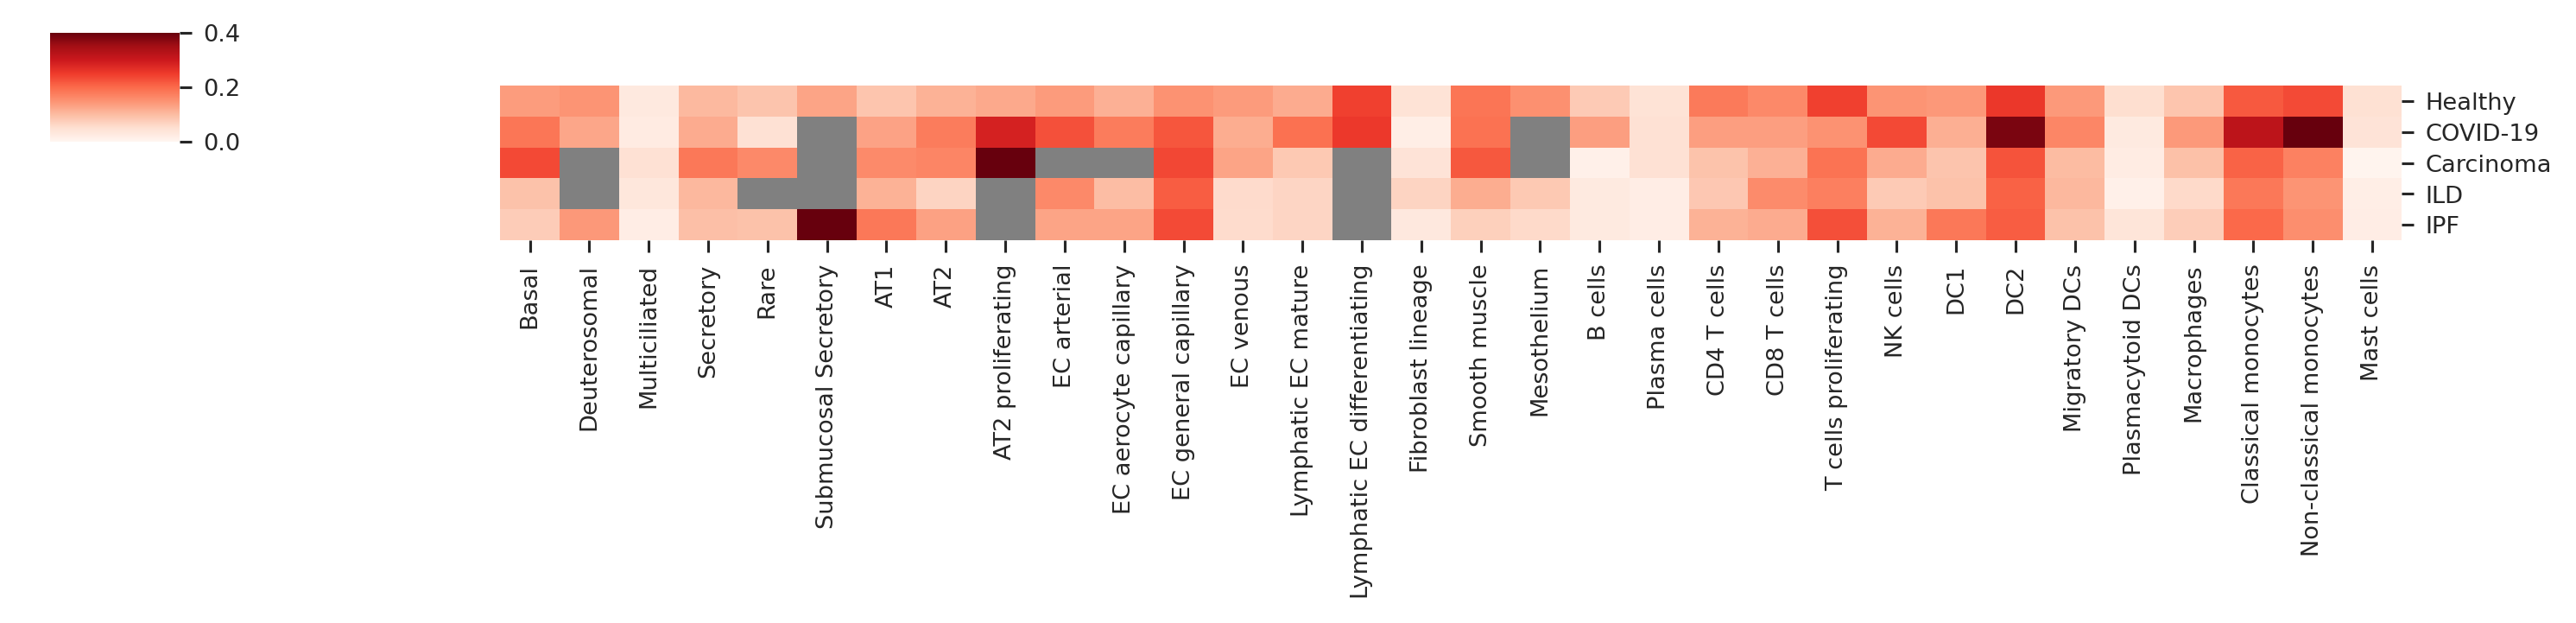

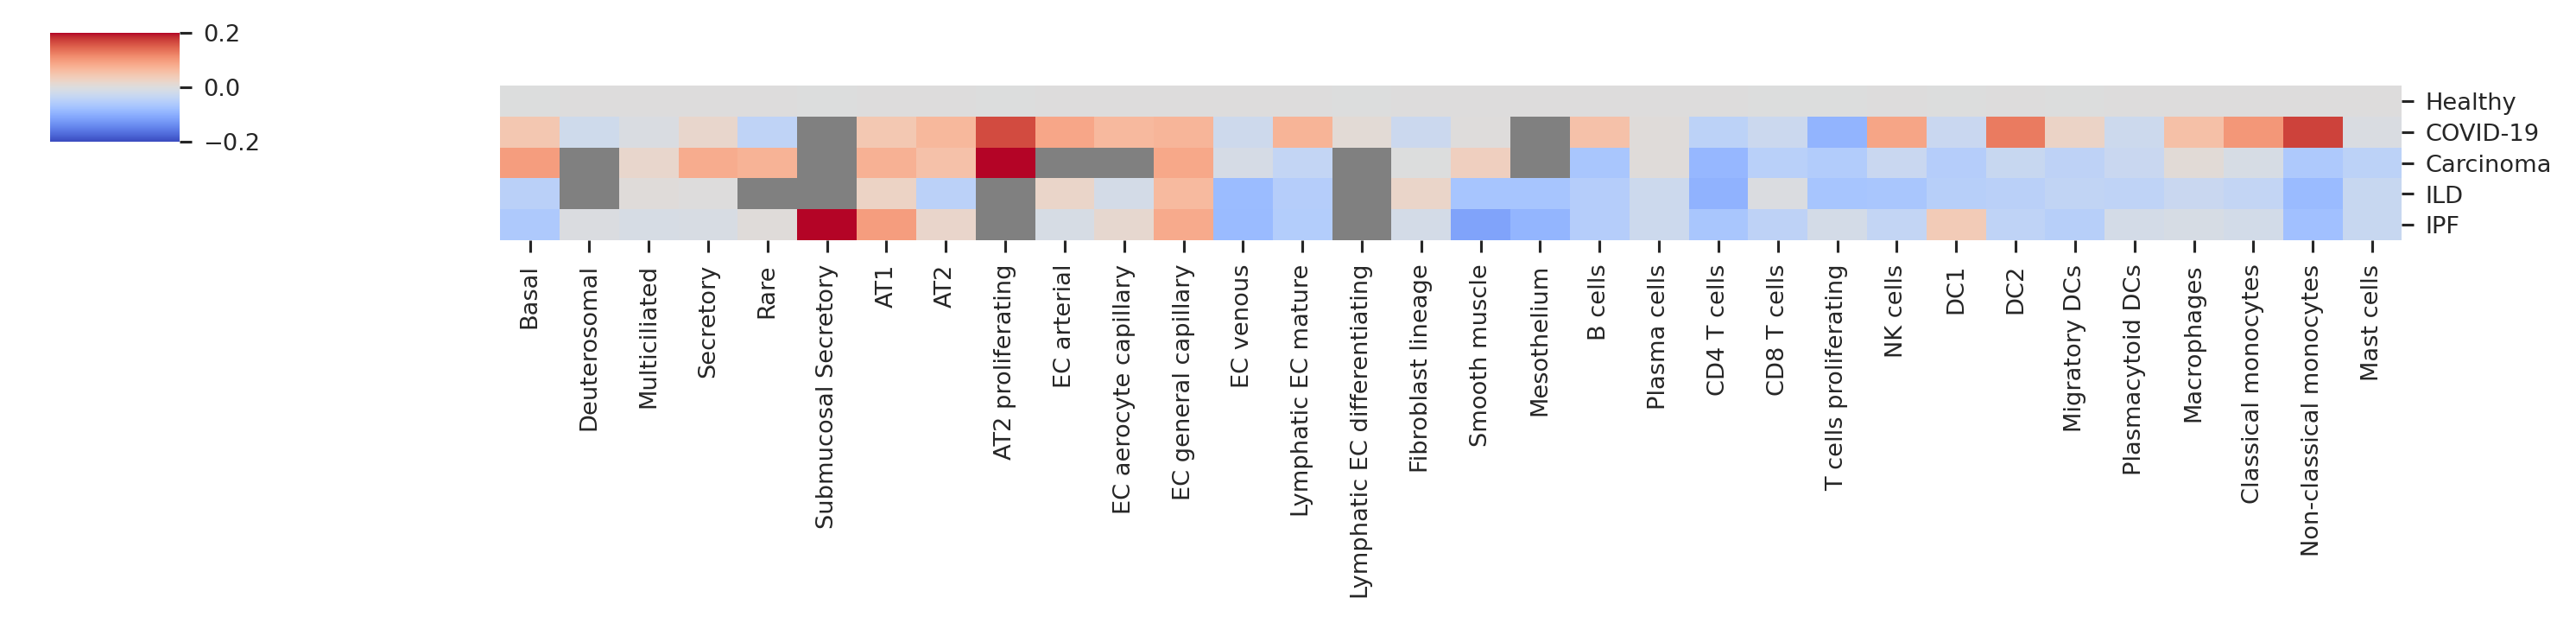

In [63]:
(_, FIGURES["ED21_ct_uncert_splitby_condition"],) = plot_ct_uncert_per_cov(
    trans,
    "condition_simpl",
    groups_to_include=groups_to_include,
    min_n_dataset=2,
    vmax=vmax,
    min_n_cells=min_n_cells,
    healthy_baseline=healthy_baseline,
)

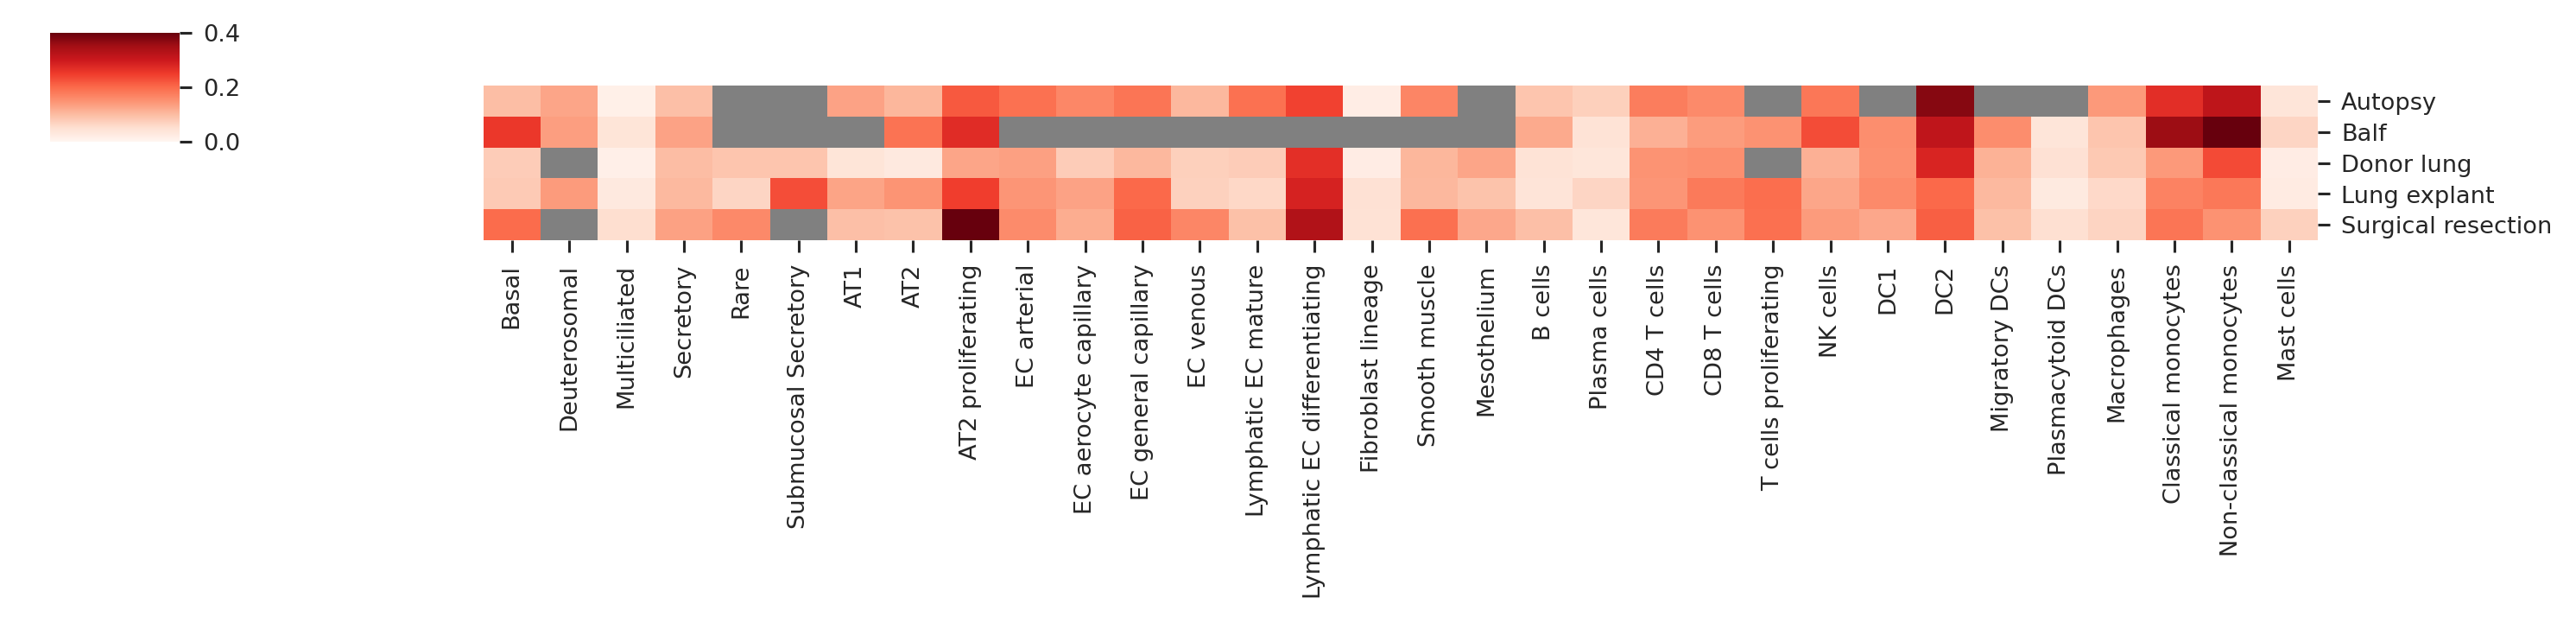

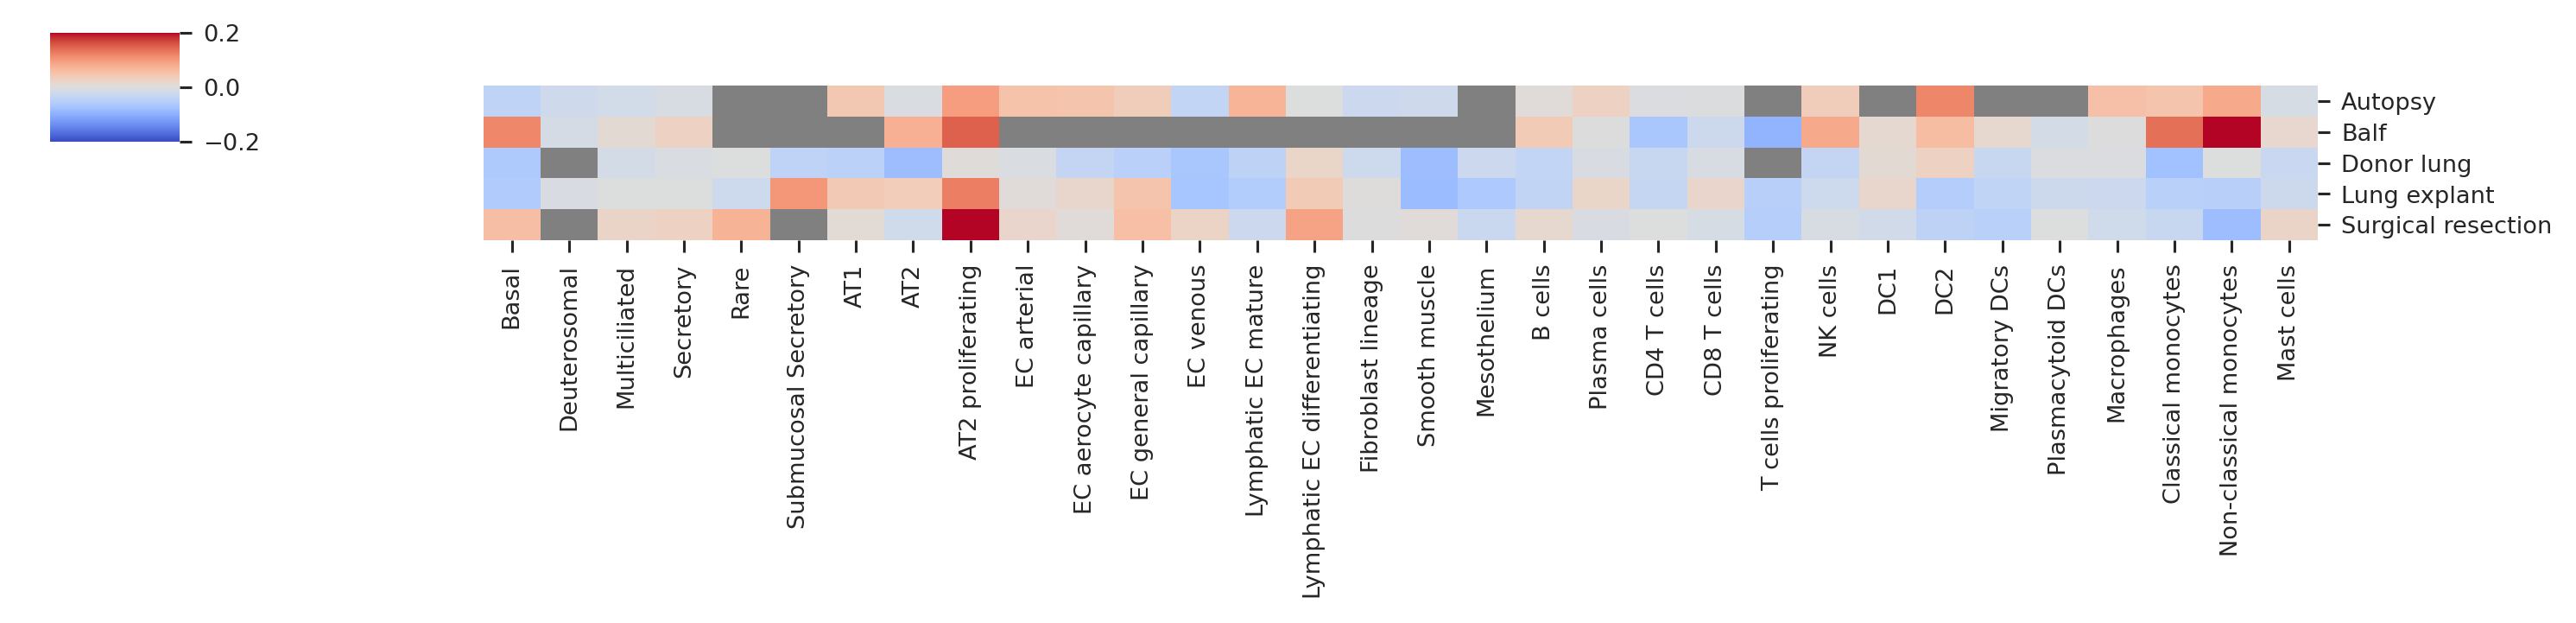

In [64]:
(_, FIGURES["ED21_ct_uncert_splitby_sample_type"],) = plot_ct_uncert_per_cov(
    trans,
    "sample_type",
    groups_to_include=groups_to_include,
    min_n_dataset=2,
    vmax=vmax,
    min_n_cells=min_n_cells,
    healthy_baseline=healthy_baseline,
)

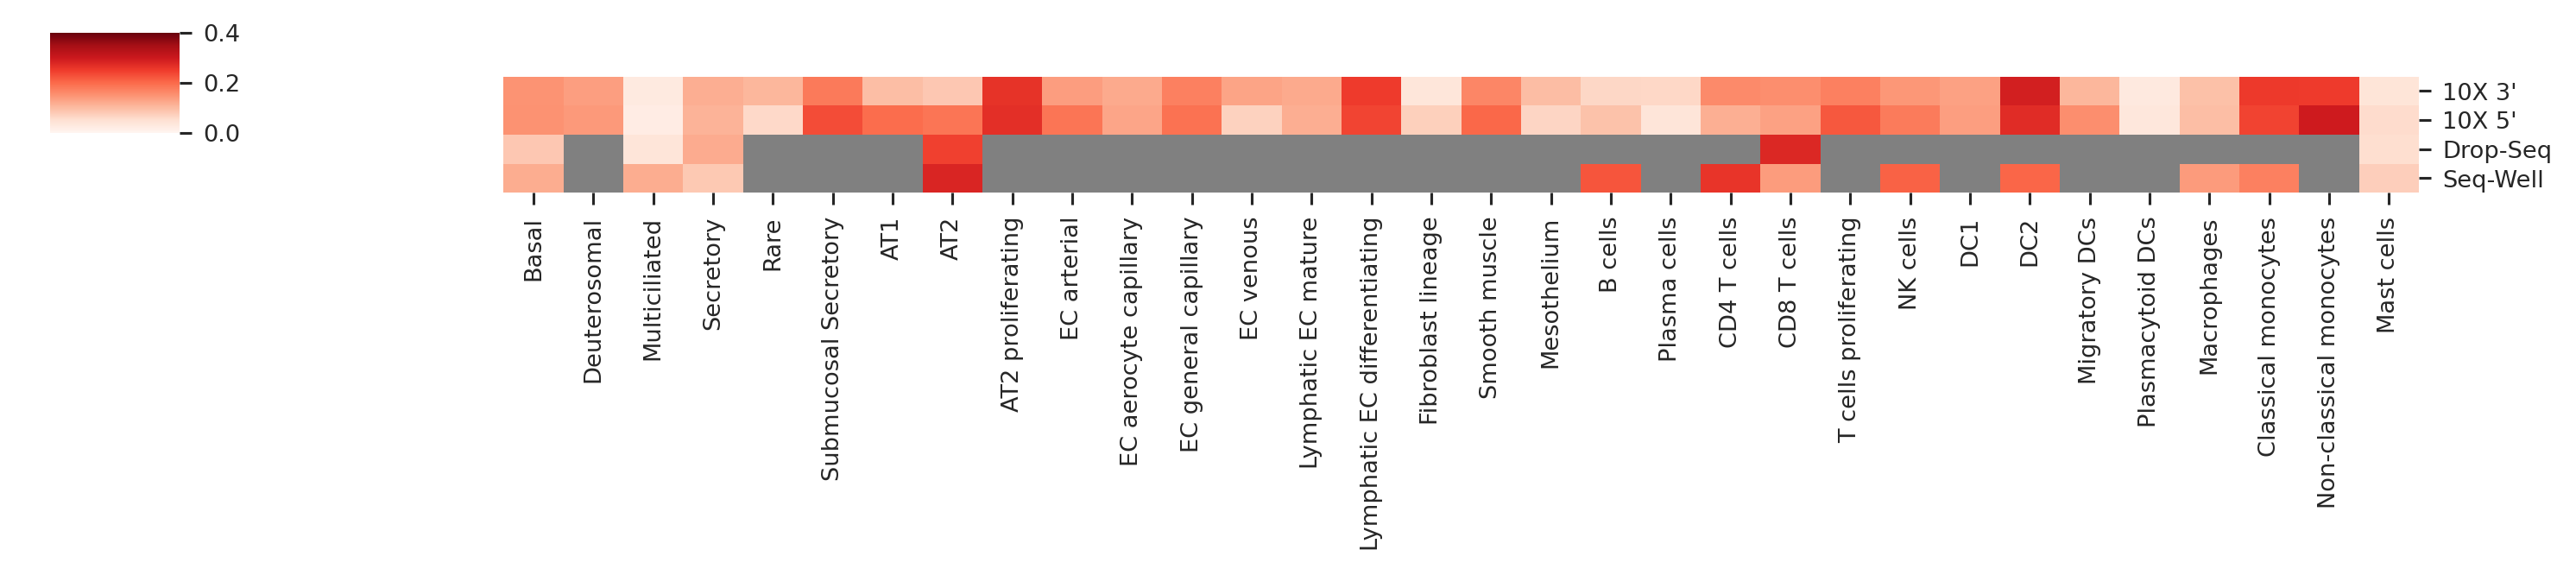

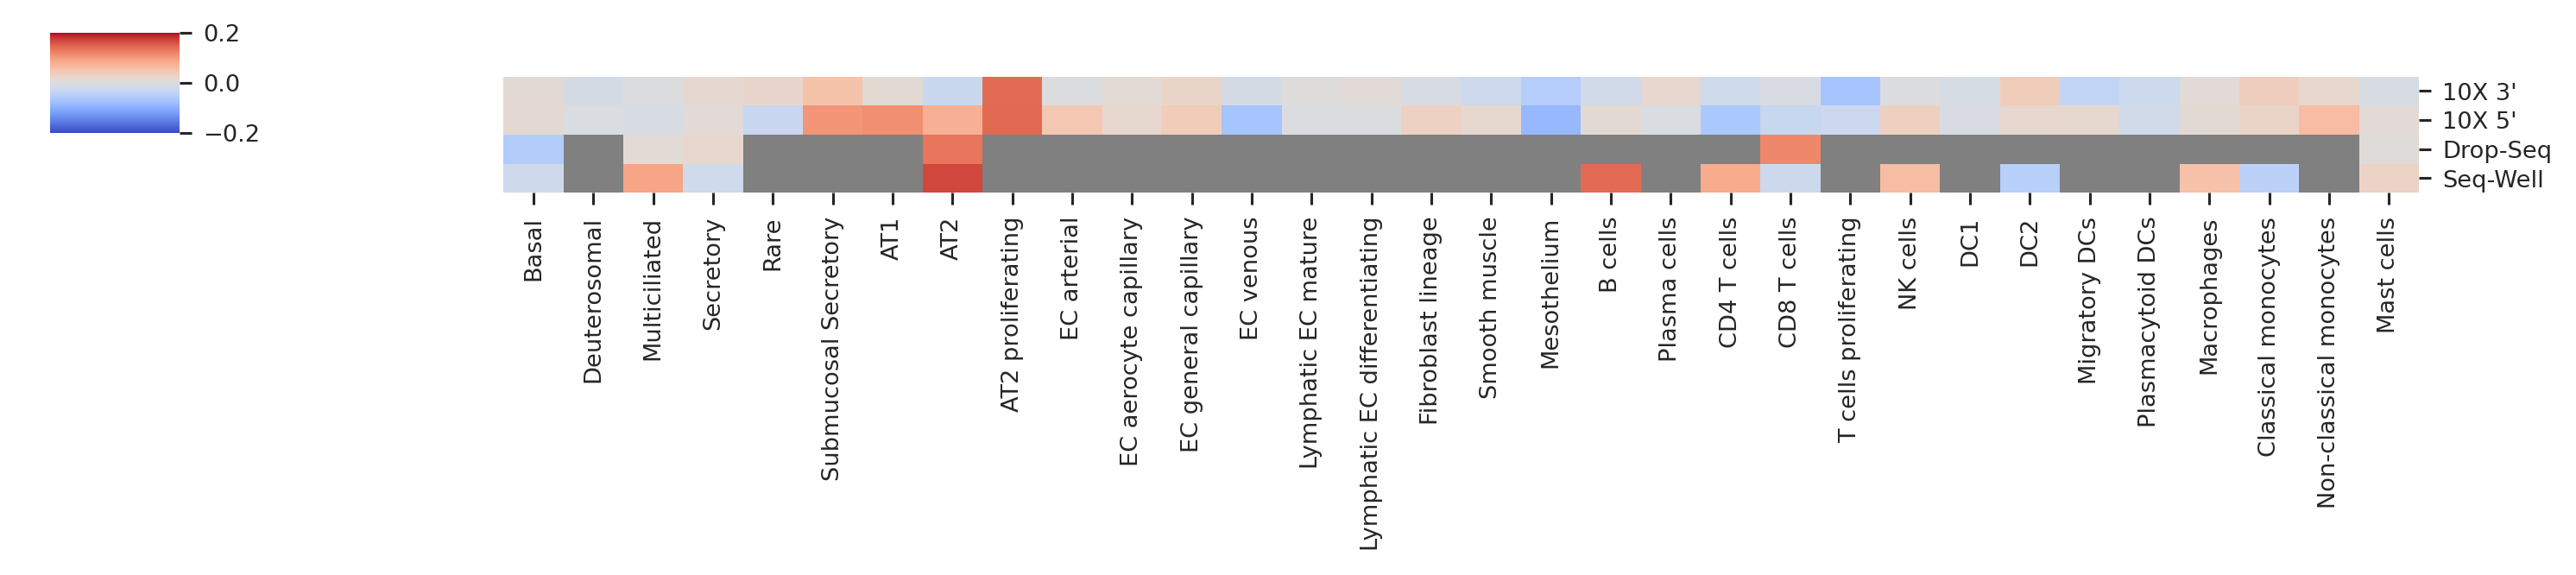

In [73]:
(_, FIGURES["ED21_ct_uncert_splitby_scplatform"],) = plot_ct_uncert_per_cov(
    trans,
    "scp_simpl",
    groups_to_include=groups_to_include,
    min_n_dataset=2,
    vmax=vmax,
    min_n_cells=min_n_cells,
    healthy_baseline=healthy_baseline,
    row_scaler=1.15,
)

In [66]:
cov = "sample_type"  # "scp_simpl"

In [67]:
test2 = pd.DataFrame(
    trans.groupby([cov, "dataset"])["condition_simpl"].apply(
        lambda x: list(np.unique(x))
    )
)
test2_healthy = test2.loc[[cond == ["Healthy"] for cond in test2.condition_simpl], :]

In [68]:
datasets_per_cov = test2.index.get_level_values(0).value_counts()
healthy_datasets_per_cov = test2_healthy.index.get_level_values(0).value_counts()
for cat in groups_to_include[cov]:
    if cat not in healthy_datasets_per_cov.index:
        healthy_datasets_per_cov[cat] = 0
frac_healthy_ds_per_cov = (
    healthy_datasets_per_cov / datasets_per_cov.loc[healthy_datasets_per_cov.index]
)

Fraction of healthy datasets per covariate:

In [69]:
frac_healthy_ds_per_cov.sort_values(ascending=False)

donor_lung                  0.108108
donor_lung_cryopreserved    0.108108
surgical_resection          0.108108
autopsy                     0.027027
balf                        0.027027
brush                       0.027027
autopsy_cryopreserved       0.000000
balf_cryopreserved          0.000000
biopsy                      0.000000
biopsy_cryopreserved        0.000000
lung_explant                0.000000
scraping                    0.000000
Name: sample_type, dtype: float64

## Store figures:

In [74]:
FIGURES

{'ED_migratory_dcs_violin_extended_atlas_dcs': <Figure size 560x140 with 1 Axes>,
 'ED_migratory_dcs_violin_extended_atlas_mdcs': <Figure size 560x140 with 1 Axes>,
 'ED_ct_uncert_splitby_condition': <seaborn.matrix.ClusterGrid at 0x7f45122faad0>,
 'ED_ct_uncert_splitby_sample_type': <seaborn.matrix.ClusterGrid at 0x7f45140fc610>,
 'ED_ct_uncert_splitby_scplatform': <seaborn.matrix.ClusterGrid at 0x7f450f6d41d0>}

In [75]:
for figname, fig in FIGURES.items():
    print("Storing", figname)
    fig.savefig(
        os.path.join(dir_figures, f"{figname}.png"),
        bbox_inches="tight",
        dpi=140,
        transparent=True,
    )
    plt.close()

Storing ED_migratory_dcs_violin_extended_atlas_dcs
Storing ED_migratory_dcs_violin_extended_atlas_mdcs
Storing ED_ct_uncert_splitby_condition
Storing ED_ct_uncert_splitby_sample_type
Storing ED_ct_uncert_splitby_scplatform
